This Jupyter notebook contains the GNNExplainer method.

In [1]:
import os

import pandas as pd
import networkx as nx
import numpy as np
import torch

import pickle
import copy

import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

from collections import Counter

# Set Parameters

In [2]:
dataset_nr = 1
assert dataset_nr == 1 or 2

embedding_method = 'e2v'
assert embedding_method == 'e2v' or 'm2v'

seeded_emb = True
assert seeded_emb == True or False

if seeded_emb:
    fixed_emb = '_seeded'
else:
    fixed_emb = ''

# Set Folder

In [3]:
curr_working_dir = os.getcwd()
curr_output_dir = os.path.join(curr_working_dir, 'output')
dataset_output_dir = os.path.join(curr_output_dir, f'g{dataset_nr}_{embedding_method}{fixed_emb}')

if not os.path.exists(dataset_output_dir):
    print('First, run the edge2vec embedding and predictor script. Then, run this script.')
else:
    print(f'Output folder for dataset {dataset_nr} already exists and will be used: {dataset_output_dir}')
    
run_folders_list = []
for item in os.listdir(dataset_output_dir):
    curr_path = os.path.join(dataset_output_dir, item)
    if os.path.isdir(curr_path) and 'run' in item:
        run_folders_list.append(item)
        
if len(run_folders_list) > 0:
    run_folders_list.sort(reverse=True)
    #latest_run = run_folders_list[0]
    latest_run = 'run_002'
    
    run_dir = os.path.join(dataset_output_dir, latest_run)
    
    expl_output_dir = os.path.join(run_dir, 'expl')
    if not os.path.exists(expl_output_dir):
        os.mkdir(expl_output_dir)
        print(f'Output folder for predictions from dataset {dataset_nr} is created: {expl_output_dir}')
    else:
        print(f'Output folder for predictions from dataset {dataset_nr} already exists and will be used: {expl_output_dir}')
    
else:
    print('First, run the edge2vec embedding and predictor script. Then, run this script.')

Output folder for dataset 1 already exists and will be used: c:\Users\rosa-\Google Drive\Msc_Bioinformatics\thesis\XAIFO-ThesisProject\output\g1_e2v
Output folder for predictions from dataset 1 already exists and will be used: c:\Users\rosa-\Google Drive\Msc_Bioinformatics\thesis\XAIFO-ThesisProject\output\g1_e2v\run_001\expl


# Load all data

Load the nodes

In [4]:
nodes = pd.read_csv(f'output/indexed_nodes_{dataset_nr}.csv')
nodes

,index_id,id,semantic,label,semantic_id
0,0,WormBase:WBGene00000389,ORTH,cdc-25.4,5
1,1,ZP:0018675,DISO,right side lateral plate mesoderm mislocalised...,1
2,2,ZFIN:ZDB-GENE-040426-1197,ORTH,tbc1d5,5
3,3,5,DRUG,(S)-nicardipine,2
4,4,RGD:3443,ORTH,Ptk2,5
...,...,...,...,...,...
10029,10029,MP:0009763,DISO,increased sensitivity to induced morbidity/mor...,1
10030,10030,MP:0011057,DISO,absent brain ependyma motile cilia,1
10031,10031,MP:0001412,DISO,excessive scratching,1
10032,10032,WBPhenotype:0004023,DISO,frequency of body bend variant,1


In [5]:
nodes.iloc[5487]

index_id            5487
id             HGNC:6717
semantic            GENE
label              LTBP4
semantic_id            3
Name: 5487, dtype: object

In [6]:
node_labels_dict = nodes[['semantic_id', 'semantic']].drop_duplicates().set_index('semantic_id').to_dict()['semantic']
node_labels_dict

{5: 'ORTH',
 1: 'DISO',
 2: 'DRUG',
 4: 'GENO',
 7: 'VARI',
 3: 'GENE',
 0: 'ANAT',
 6: 'PHYS'}

Load the node embeddings

In [7]:
def loadEdge2VecEmbedding(): 
    node_feat = KeyedVectors.load(f'{run_dir}/w2v_{dataset_nr}.dvectors', mmap='r')
    e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
    for idx, key in enumerate(node_feat.index_to_key):
        e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(node_feat[key])})
        
    return e2v_embedding.sort_values('Node')

def loadMetapath2VecEmbedding():
    metapath2vec_embedding = pd.read_csv(f'{run_dir}/metapath2vec_embedding_{dataset_nr}.csv')
    metapath2vec_embedding['Embedding'] = metapath2vec_embedding.values.tolist()
    metapath2vec_embedding = metapath2vec_embedding[['Embedding']]
    metapath2vec_embedding['Node'] = metapath2vec_embedding.index
    return metapath2vec_embedding[['Node', 'Embedding']]

In [8]:
if embedding_method == 'e2v':
    embedding = loadEdge2VecEmbedding()
else:
    embedding = loadMetapath2VecEmbedding()
    
embedding

,Node,Embedding
0,0,"[-0.80172193, -0.31312022, 1.3363898, 0.047870..."
1,1,"[-0.43657017, -0.59252596, 0.21464153, 0.28127..."
2,2,"[-0.6035868, -0.81537753, -0.1698302, 0.029323..."
3,3,"[-0.25198308, -0.5973693, 0.116735026, 0.15848..."
4,4,"[-0.567523, -0.6277393, 0.22508189, 0.17768621..."
...,...,...
10029,10029,"[-0.3428445, -0.65736985, 0.1452774, 0.1707272..."
10030,10030,"[-0.28449383, -0.7016132, 0.23477365, 0.197892..."
10031,10031,"[-0.30933982, -0.7699769, 0.20634678, -0.03841..."
10032,10032,"[-0.6069677, -1.102868, 0.45715353, 0.82833016..."


Load the edges

In [9]:
edges = pd.read_csv(f'output/indexed_edges_{dataset_nr}.csv')
edges

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail,type
0,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,FlyBase:FBgn0085464,CG34435,5,6825,0
1,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,HGNC:7585,MYL4,3,27,0
2,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,FlyBase:FBgn0002772,Mlc1,5,8901,0
3,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,NCBIGene:396472,MYL4,3,9508,0
4,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in 1 to 1 orthology relationship with,ENSEMBL:ENSECAG00000020967,ENSEMBL:ENSECAG00000020967,5,8807,1
...,...,...,...,...,...,...,...,...,...,...
82908,4810,ibrutinib,2,1618,targets,HGNC:11283,SRC,3,3279,14
82909,522,carvedilol,2,184,targets,HGNC:620,APP,3,547,14
82910,OMIM:300377.0013,"DMD, EX18DEL",1,2822,is allele of,HGNC:2928,DMD,3,6612,16
82911,Coriell:GM05113,NIGMS-GM05113,4,8105,has role in modeling,MONDO:0010679,Duchenne muscular dystrophy,1,6315,15


Initialize a graph with edges and nodes including the embedding features of each node.

In [10]:
G = nx.Graph() # TODO: DiGraph?
for ind, node in embedding.iterrows(): 
    G.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
for ind, edge in edges.iterrows(): 
    G.add_edge(int(edge['index_head']), int(edge['index_tail']), edge_label = edge['relation'])
  
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

(0, {'node_feature': tensor([-0.8017, -0.3131,  1.3364,  0.0479,  0.1519,  0.0036,  0.0339, -0.2446,
         1.2985, -0.1459, -0.3350, -1.2716, -1.1471,  0.2593, -0.3035, -1.1219,
        -0.0516, -0.6955, -0.2582,  2.0766, -0.1314,  1.2659, -0.3483, -0.8218,
         1.4621, -0.6987, -0.0468,  0.3544, -0.2787, -0.7689,  0.3949, -0.3567])})
(0, 5765, {'edge_label': 'interacts with'})
Number of edges is 52024
Number of nodes is 10034


In [11]:
edge_labels_dict = dict([((n1, n2), G.edges[(n1,n2)]['edge_label']) for n1, n2 in G.edges])
edge_labels_dict

{(0, 5765): 'interacts with',
 (0, 1681): 'in orthology relationship with',
 (0, 8615): 'in orthology relationship with',
 (0, 363): 'in orthology relationship with',
 (0, 5156): 'in orthology relationship with',
 (0, 8473): 'in orthology relationship with',
 (0, 6666): 'in orthology relationship with',
 (0, 5248): 'in 1 to 1 orthology relationship with',
 (0, 3961): 'in orthology relationship with',
 (0, 9835): 'in 1 to 1 orthology relationship with',
 (0, 2619): 'in orthology relationship with',
 (0, 8756): 'in orthology relationship with',
 (0, 1856): 'in orthology relationship with',
 (0, 3670): 'in 1 to 1 orthology relationship with',
 (0, 10028): 'in 1 to 1 orthology relationship with',
 (0, 6308): 'in orthology relationship with',
 (0, 2226): 'in orthology relationship with',
 (0, 8710): 'in orthology relationship with',
 (0, 5949): 'in orthology relationship with',
 (0, 2139): 'in orthology relationship with',
 (0, 9308): 'has phenotype',
 (0, 71): 'has phenotype',
 (1, 6012): 

Load trained model

In [12]:
from gnn.linkpred_model import LinkPredModel

with open(f'{run_dir}/best_model_{dataset_nr}_{embedding_method}_args.pkl', 'rb') as f:
    loaded_args = pickle.load(f)
    
best_model = LinkPredModel(len(embedding['Embedding'][0]), 
                           loaded_args['hidden_dim'], loaded_args['output_dim'], 
                           loaded_args['layers'], loaded_args['aggr'], 
                           loaded_args['dropout'], loaded_args['device']).to(loaded_args['device'])
best_model.load_state_dict(torch.load(f'{run_dir}/best_model_{dataset_nr}_{embedding_method}.pth'))

<All keys matched successfully>

# Explain predictions

In [13]:
x = torch.Tensor(embedding['Embedding'])
print(x.shape)

torch.Size([10034, 32])


In [14]:
edge_index = torch.Tensor(np.array(G.edges).transpose()).type(torch.int64).long()
print(edge_index.shape)

torch.Size([2, 52024])


In [15]:
nx.is_directed(G)

False

In [16]:
from gnn.gnnexplainer import GNNExplainer, visualize_subgraph

num_hops = 1

def explain_edge(node_idx1, node_idx2):
    explainer = GNNExplainer(best_model,
                             epochs=700, num_hops=num_hops, lr=0.01)
    
    trigger = False
    early_stop = 0
    size = 15   # change size of the explanation graph
    iterations = 50 # number of times GNNExplainer is executed
    
    while not trigger:
        _, edge_mask = explainer.explain_link(node_idx1=node_idx1, node_idx2=node_idx2,
                                              x=x, edge_index=edge_index,
                                              G=G)
        
        G2 = copy.deepcopy(G)
        
        if size is not None:
            limit = edge_mask.sort(descending = True)[0][size]
            print('Contribution threshold is', limit)
        else:
            limit = 0.5
        
        for indx, edge in enumerate(G.edges): 
            if edge_mask[indx] < limit:
                G2.remove_edge(edge[0], edge[1])
        
        if nx.has_path(G2, node_idx1, node_idx2) and torch.is_nonzero(limit):
            trigger = True
            
        early_stop += 1
        
        if early_stop == iterations and not trigger:
            print('No good explanation found after {} iterations'.format(early_stop))
            trigger = True
        elif trigger: 
            print('Explanation found!')
            return edge_mask, limit
        
    return None, None
    

In [19]:
symptoms_drugs = pd.read_pickle(f'{run_dir}/pred/candidates_per_symptom_{dataset_nr}_{embedding_method}.pkl')
symptoms_drugs

,Symptom,Candidates
0,HP:0011675,"[231, 1576, 1947]"
1,HP:0002515,"[4318, 624, 4225]"
2,HP:0003236,"[231, 4318, 1576]"
3,HP:0002093,"[4318, 624, 94]"
4,HP:0003707,"[4318, 332, 305]"
5,HP:0001256,"[4318, 332, 2052]"
6,HP:0003701,"[4318, 4225, 624]"
7,HP:0003202,"[4318, 624, 4225]"
8,HP:0003560,"[624, 231, 5359]"
9,HP:0003391,"[4318, 2052, 4225]"


In [20]:
def get_node_idx(id, nodes): 
    return nodes[nodes['id'] == id].index.values.astype(int)[0]

found_explanation = []

for ind, edge in symptoms_drugs.iterrows(): 
    symptom_id = edge['Symptom']
    
    for drug_id in edge['Candidates']:
        node_idx1 = get_node_idx(symptom_id, nodes)
        print('node1:')
        print(nodes.loc[[node_idx1]])

        node_idx2 = get_node_idx(str(drug_id), nodes)
        print('node2:')
        print(nodes.loc[[node_idx2]])
        
        found_edge_mask, found_limit = explain_edge(node_idx1, node_idx2)
        
        if found_edge_mask is not None and found_limit is not None:
            found_explanation.append({'symptom': symptom_id, 'drug': drug_id, 'node_idx1': node_idx1, 'node_idx2': node_idx2, 'found_edge_mask': found_edge_mask, 'found_limit': found_limit})

node1:
      index_id          id semantic       label  semantic_id
9512      9512  HP:0011675     DISO  Arrhythmia            1
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.5094], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 418.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 451.52it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5513], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 433.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5662], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 456.34it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 493.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 487.42it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 490.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 481.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 498.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 440.07it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5359], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 465.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6700], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 456.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 493.31it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 495.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5776], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 500.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5314], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 478.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 502.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5330], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 501.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 483.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5226], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 443.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4974], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 494.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 459.14it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 438.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 427.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 450.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 466.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5381], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 466.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5819], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 506.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5620], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 495.29it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 505.52it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6117], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 429.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 483.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4848], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 508.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 506.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 508.79it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5367], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 498.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 499.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6379], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 486.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5617], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 503.33it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 487.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 512.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 492.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 506.87it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 493.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 489.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5718], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 480.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5132], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 482.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 499.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 497.46it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5735], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 86: 100%|██████████| 700/700 [00:01<00:00, 493.13it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id semantic       label  semantic_id
9512      9512  HP:0011675     DISO  Arrhythmia            1
node2:
     index_id    id semantic         label  semantic_id
517       517  1576     DRUG  levosimendan            2
Prediction from trained model: tensor([0.4234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 500.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 497.88it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4261], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 482.62it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 484.55it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4734], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 494.53it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 503.39it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 503.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4197], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 500.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 502.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 500.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4566], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 491.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 492.71it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 495.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 493.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 509.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 496.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4404], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 501.68it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4282], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 464.87it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 481.34it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 483.96it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 494.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 458.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4476], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 489.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3402], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 457.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 459.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 497.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 490.27it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4270], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 496.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 484.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 487.26it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 499.26it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 499.17it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3999], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 501.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 480.87it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4354], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 505.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3880], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 501.69it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 496.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4214], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 508.54it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4012], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 505.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4325], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 495.97it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 480.23it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3910], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 470.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 500.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 498.86it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 505.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 458.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 471.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4074], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 499.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 492.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 517: 100%|██████████| 700/700 [00:01<00:00, 504.52it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic       label  semantic_id
9512      9512  HP:0011675     DISO  Arrhythmia            1
node2:
     index_id    id semantic         label  semantic_id
642       642  1947     DRUG  nitrendipine            2
Prediction from trained model: tensor([0.7342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 490.66it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7230], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 447.17it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 471.04it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 472.10it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 470.88it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 500.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6292], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 495.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 509.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 502.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 493.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6061], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 459.29it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6676], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 479.81it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7753], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 464.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 442.51it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 464.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 496.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 484.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 490.62it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 493.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7390], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 508.21it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 504.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 492.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 508.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6319], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 508.06it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 475.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7753], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 489.42it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 502.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 511.37it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7558], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 484.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7496], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 422.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 372.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 355.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 411.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 440.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 439.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6792], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 398.88it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 421.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 443.69it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 458.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7620], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 441.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 453.90it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 437.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6960], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 455.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6228], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 494.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6357], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 454.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 496.09it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 501.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 513.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 506.85it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7666], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 642: 100%|██████████| 700/700 [00:01<00:00, 494.93it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
     index_id          id semantic          label  semantic_id
552       552  HP:0002515     DISO  Waddling gait            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.3871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 621.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 557.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 546.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4763], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 615.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 558.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 562.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 602.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 561.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 481.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 613.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 542.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 517.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 525.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 613.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4860], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 533.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 592.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 609.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 625.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4173], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 632.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 595.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5127], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 620.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 586.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3317], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 621.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 635.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5476], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 606.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 601.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 626.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 545.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4548], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 427.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 547.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4330], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 598.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4850], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 608.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 609.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4402], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 621.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 580.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 511.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 546.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3846], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 633.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3898], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 613.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 629.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4513], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 613.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 624.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 631.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5304], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 591.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4235], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 626.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3338], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1456: 100%|██████████| 700/700 [00:01<00:00, 614.83it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id semantic          label  semantic_id
552       552  HP:0002515     DISO  Waddling gait            1
node2:
     index_id   id semantic              label  semantic_id
208       208  624     DRUG  chlortetracycline            2
Prediction from trained model: tensor([0.5266], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 597.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4420], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 617.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 614.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 618.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3991], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 627.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4416], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 568.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 519.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4062], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 596.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4406], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 535.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5549], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 479.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5365], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 535.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 590.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3678], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 473.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4729], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 533.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5327], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 578.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 572.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 561.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 625.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 529.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 585.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 611.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5146], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 587.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 569.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 572.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 609.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 595.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 529.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4110], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 621.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 520.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4813], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 538.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 600.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 517.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4642], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 596.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 592.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5023], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 555.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 607.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5551], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 588.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3194], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 571.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 594.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 575.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5186], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 553.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4237], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 607.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 600.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 554.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 611.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4925], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 560.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 583.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 560.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 493.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4577], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 208: 100%|██████████| 700/700 [00:01<00:00, 524.64it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id semantic          label  semantic_id
552       552  HP:0002515     DISO  Waddling gait            1
node2:
      index_id    id semantic     label  semantic_id
1420      1420  4225     DRUG  axitinib            2
Prediction from trained model: tensor([0.5650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 597.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 478.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5742], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 540.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5890], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 587.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5560], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 595.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5655], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 526.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4577], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 585.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5753], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 542.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 593.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 516.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 556.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 582.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 527.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 562.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5090], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 583.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 588.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5678], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 584.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5655], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 563.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5560], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 581.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 661.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 654.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5972], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 666.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 549.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6054], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 596.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 590.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 592.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6422], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 600.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5093], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 564.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 626.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6782], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 545.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5543], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 561.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5502], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 623.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 652.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 644.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 616.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5362], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 668.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 582.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 669.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 667.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 672.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6294], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 648.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 587.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5644], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 623.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5638], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 651.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 624.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5677], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 651.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 619.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 553.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5865], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5779], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1420: 100%|██████████| 700/700 [00:01<00:00, 561.07it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                           label  \
1990      1990  HP:0003236     DISO  Elevated serum creatine kinase   

      semantic_id  
1990            1  
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.5879], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 558.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 596.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 518.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6735], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 550.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 488.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:02<00:00, 327.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 495.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3758], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 531.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5296], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 539.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 557.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5291], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 513.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5179], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 590.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5520], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 580.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 553.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3625], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 530.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4757], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 559.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 510.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 534.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 494.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 531.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 588.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 531.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6431], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 579.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 611.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5642], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 548.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 606.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6917], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 552.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 601.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 582.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 507.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5396], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 518.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6137], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 525.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4525], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 536.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 507.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5779], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 497.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5602], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 565.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 523.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 467.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:02<00:00, 270.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 553.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 554.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4971], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 516.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 383.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 585.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4449], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 529.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 584.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4327], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 522.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 536.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 504.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 86: 100%|██████████| 700/700 [00:01<00:00, 585.18it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                           label  \
1990      1990  HP:0003236     DISO  Elevated serum creatine kinase   

      semantic_id  
1990            1  
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.6842], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8255], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 602.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 605.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5744], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 577.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8195], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 539.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7711], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 565.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 553.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6720], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 580.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 560.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 584.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 574.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 516.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 583.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 509.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 524.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 559.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 506.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8238], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 567.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8410], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 505.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8458], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 502.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 582.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 596.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 491.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6357], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 611.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 535.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7636], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 582.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 529.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7403], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 528.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 510.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 398.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6172], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 546.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 545.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 482.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7265], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 560.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 567.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 506.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7744], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 469.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6991], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 509.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 603.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 574.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 596.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 585.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7521], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 519.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 590.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1456: 100%|██████████| 700/700 [00:01<00:00, 508.07it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                           label  \
1990      1990  HP:0003236     DISO  Elevated serum creatine kinase   

      semantic_id  
1990            1  
node2:
     index_id    id semantic         label  semantic_id
517       517  1576     DRUG  levosimendan            2
Prediction from trained model: tensor([0.3976], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 514.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 561.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3816], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 490.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 542.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 528.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 517.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 527.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 559.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 587.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 595.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 536.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 563.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 585.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 514.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3414], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 592.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2422], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 588.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 593.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 529.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 575.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 579.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 587.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 580.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 587.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3701], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 567.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 586.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2560], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 581.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 581.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 585.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2982], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 595.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3402], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 596.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 585.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 591.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 554.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3925], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 575.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 522.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 555.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 587.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 605.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3575], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 570.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3716], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 587.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4388], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 606.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 554.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4289], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 622.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 593.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2806], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 647.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 625.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 627.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2130], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 604.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 617.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3261], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 517: 100%|██████████| 700/700 [00:01<00:00, 569.03it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                      label  semantic_id
4440      4440  HP:0002093     DISO  Respiratory insufficiency            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.9208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 561.15it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 586.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 578.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8287], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 574.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 570.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 519.31it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 552.78it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 525.76it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 573.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9316], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 536.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 595.28it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 583.50it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8336], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 597.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9074], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 546.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8664], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 554.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9224], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 567.95it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9135], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.96it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8602], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 571.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9825], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 571.08it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9337], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 565.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 565.46it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7375], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.44it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 556.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8711], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 577.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8224], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 559.36it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8399], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 544.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7835], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 528.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 587.04it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8758], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 595.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9199], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8652], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 580.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 603.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 595.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8793], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 566.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 578.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 552.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8647], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 563.00it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 539.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 539.49it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 536.94it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1456: 100%|██████████| 700/700 [00:01<00:00, 533.18it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                      label  semantic_id
4440      4440  HP:0002093     DISO  Respiratory insufficiency            1
node2:
     index_id   id semantic              label  semantic_id
208       208  624     DRUG  chlortetracycline            2
Prediction from trained model: tensor([0.8937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 545.68it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 547.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 583.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 590.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 468.02it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 493.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7757], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 548.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 556.01it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8720], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 572.49it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 528.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8448], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 560.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 573.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 563.09it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 574.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 589.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 573.58it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 582.36it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9033], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 566.44it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 525.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 515.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 563.53it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 570.05it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8864], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 582.03it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8327], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 560.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 568.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 568.23it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 504.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 581.54it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 567.48it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 592.36it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 529.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 563.27it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 592.56it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8291], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 585.52it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 598.70it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 574.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 532.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 587.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 550.46it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 551.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8862], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 558.00it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 571.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 566.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 567.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8601], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 573.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 575.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 446.56it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 549.03it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8752], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 548.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 208: 100%|██████████| 700/700 [00:01<00:00, 566.58it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                      label  semantic_id
4440      4440  HP:0002093     DISO  Respiratory insufficiency            1
node2:
    index_id  id semantic       label  semantic_id
41        41  94     DRUG  adiphenine            2
Prediction from trained model: tensor([0.8894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 493.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9428], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 507.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 504.62it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 523.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 487.77it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 545.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9138], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 530.54it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8330], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 569.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 532.39it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 553.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 513.26it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6801], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 537.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 529.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9151], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 542.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 537.31it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 534.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 531.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 554.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 556.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9284], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 564.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 505.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 552.54it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8459], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 536.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 491.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 512.02it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8801], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 531.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 536.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 540.25it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8406], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 537.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 552.27it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9273], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 507.43it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9294], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 528.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8869], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 546.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 552.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8271], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 544.02it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8941], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 546.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8323], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 550.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 551.89it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 535.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 513.25it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 548.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 530.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8524], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 531.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 524.40it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 539.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8711], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 536.62it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7795], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 495.51it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 473.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8421], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 542.53it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 41: 100%|██████████| 700/700 [00:01<00:00, 498.49it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
     index_id          id semantic                          label  semantic_id
357       357  HP:0003707     DISO  Calf muscle pseudohypertrophy            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.3060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 672.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 653.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 652.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2318], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 644.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3181], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 663.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2509], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 645.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 657.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3131], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 653.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4237], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 653.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 612.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2560], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 611.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 665.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.1911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3574], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 606.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2561], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 634.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2104], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 670.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3197], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 647.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4072], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 655.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 661.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2380], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 618.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 631.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 613.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 687.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 683.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 639.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3181], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 668.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3301], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 657.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 671.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2538], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 634.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 673.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 657.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 675.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2031], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 670.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 664.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3744], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 647.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3188], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 647.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 609.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 596.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4230], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 602.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 627.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 655.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 625.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 667.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 651.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2410], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 656.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 633.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 584.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 667.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2265], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 625.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1456: 100%|██████████| 700/700 [00:01<00:00, 657.09it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id semantic                          label  semantic_id
357       357  HP:0003707     DISO  Calf muscle pseudohypertrophy            1
node2:
     index_id   id semantic         label  semantic_id
130       130  332     DRUG  benzthiazide            2
Prediction from trained model: tensor([0.5215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 622.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 640.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 635.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6674], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 643.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6642], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 641.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 646.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 625.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6972], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 647.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 644.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 609.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5715], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 638.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 557.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 646.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 648.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7190], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 611.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7114], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 641.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 656.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6513], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 642.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 618.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6140], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 571.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7284], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 628.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6222], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 611.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 639.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6601], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 643.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6230], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 646.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6552], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 591.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 605.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 685.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 672.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 670.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 691.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6203], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 666.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 681.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 685.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 689.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 686.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6416], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 692.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 693.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6749], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 695.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 679.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 679.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 664.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6445], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 573.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6372], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 601.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 595.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6366], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 636.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 657.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6525], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 671.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 688.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6179], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 130: 100%|██████████| 700/700 [00:01<00:00, 669.08it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id semantic                          label  semantic_id
357       357  HP:0003707     DISO  Calf muscle pseudohypertrophy            1
node2:
     index_id   id semantic                label  semantic_id
118       118  305     DRUG  bendroflumethiazide            2
Prediction from trained model: tensor([0.5897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:00<00:00, 705.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5701], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 681.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:00<00:00, 700.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6286], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 692.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7333], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 682.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6007], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 695.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6228], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 684.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:00<00:00, 709.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 680.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 668.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 688.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 685.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 690.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 668.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6449], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:00<00:00, 711.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:00<00:00, 701.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5574], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 687.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 683.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6321], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 693.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6543], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:00<00:00, 701.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7151], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 656.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 650.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6924], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 693.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 647.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 659.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 696.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6301], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 688.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 663.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 690.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 684.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:00<00:00, 702.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 680.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 688.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6862], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 670.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 684.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 680.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6080], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:00<00:00, 706.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 697.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 698.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7286], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 698.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 698.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 698.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 689.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6528], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 679.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7779], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 696.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 618.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 675.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 665.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 630.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 118: 100%|██████████| 700/700 [00:01<00:00, 691.52it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                          label  \
4247      4247  HP:0001256     DISO  Intellectual disability, mild   

      semantic_id  
4247            1  
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.8841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 643.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8653], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 675.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 684.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 657.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9284], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 677.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8924], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 671.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9421], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 675.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 696.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 692.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 694.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 679.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 688.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9453], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 692.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9282], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 695.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9045], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:00<00:00, 719.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 674.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 694.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 679.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:00<00:00, 725.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 698.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 685.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9548], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 626.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 681.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 690.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9173], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 694.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:00<00:00, 705.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 672.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 697.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9548], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 690.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9221], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 687.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:00<00:00, 702.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 697.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 697.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 697.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 691.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:00<00:00, 704.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:00<00:00, 701.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9353], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 659.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 694.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 688.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 694.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8797], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 679.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 681.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:00<00:00, 704.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 647.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:00<00:00, 709.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8179], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 639.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8729], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:00<00:00, 705.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1456: 100%|██████████| 700/700 [00:01<00:00, 688.02it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                          label  \
4247      4247  HP:0001256     DISO  Intellectual disability, mild   

      semantic_id  
4247            1  
node2:
     index_id   id semantic         label  semantic_id
130       130  332     DRUG  benzthiazide            2
Prediction from trained model: tensor([0.3708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:00<00:00, 705.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 693.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4920], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 692.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 683.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3561], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:00<00:00, 701.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 692.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:00<00:00, 702.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 668.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4104], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 539.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 644.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 640.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 676.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3478], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 698.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 681.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5069], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 688.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 573.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 674.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3754], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 679.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 677.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 688.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:00<00:00, 704.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 624.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4702], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:00<00:00, 710.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:00<00:00, 701.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:00<00:00, 712.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 692.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:00<00:00, 704.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 677.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5001], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 693.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4021], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:00<00:00, 703.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 694.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3524], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 677.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4303], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 692.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 678.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 688.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 689.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:00<00:00, 705.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 696.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3530], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 692.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4472], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:00<00:00, 705.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 686.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 699.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4520], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 662.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3368], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 696.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:00<00:00, 701.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 699.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 694.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4792], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 638.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 623.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 130: 100%|██████████| 700/700 [00:01<00:00, 699.43it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                          label  \
4247      4247  HP:0001256     DISO  Intellectual disability, mild   

      semantic_id  
4247            1  
node2:
     index_id    id semantic        label  semantic_id
675       675  2052     DRUG  pancuronium            2
Prediction from trained model: tensor([0.6923], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 672.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 646.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7241], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 666.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 650.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 662.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 680.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6404], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 658.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 683.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 667.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 650.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 675.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 660.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 651.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6284], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 682.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8317], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 658.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8639], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 653.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6914], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 659.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5972], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 657.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 665.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6522], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 663.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 670.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 662.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7865], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 665.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 633.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 642.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 672.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7827], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 684.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7266], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 671.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8431], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 654.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 648.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7644], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 662.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 649.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 670.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7134], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 661.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7287], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 674.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 646.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8176], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 667.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8304], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:00<00:00, 704.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8036], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 654.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6173], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 667.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 656.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6649], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 669.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7399], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 653.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 682.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7418], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 668.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 674.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7162], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 667.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 660.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7720], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 616.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 675: 100%|██████████| 700/700 [00:01<00:00, 631.76it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                     label  semantic_id
5299      5299  HP:0003701     DISO  Proximal muscle weakness            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.9010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 610.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 606.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8843], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 607.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8421], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 611.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 608.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 455.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 468.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 532.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 580.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 509.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 600.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 612.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 468.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 608.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 584.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9357], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 624.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 618.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 608.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 622.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 601.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 602.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9228], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 600.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 502.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9140], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 619.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 613.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 591.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 595.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7834], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 611.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 604.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8449], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 618.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9077], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 599.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 606.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 616.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8532], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 612.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 610.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 586.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 608.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9191], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 603.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 619.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8834], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 601.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9467], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 617.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8502], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 603.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8641], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 612.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7678], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 620.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 587.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 536.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 616.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9097], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1456: 100%|██████████| 700/700 [00:01<00:00, 608.19it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                     label  semantic_id
5299      5299  HP:0003701     DISO  Proximal muscle weakness            1
node2:
      index_id    id semantic     label  semantic_id
1420      1420  4225     DRUG  axitinib            2
Prediction from trained model: tensor([0.6871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 610.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 600.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7123], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 613.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 603.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 613.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 614.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 612.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 597.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7258], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 603.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 620.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7488], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 616.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 609.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 603.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 610.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 606.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 618.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 611.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7647], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 620.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 616.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 605.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 565.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 579.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6901], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 604.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7266], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 611.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6197], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 619.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 601.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 615.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 601.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6715], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 616.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7579], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 619.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 591.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6927], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 604.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6568], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 610.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 609.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6328], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 606.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 603.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8616], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 590.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 604.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 609.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7349], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 604.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 611.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 606.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7220], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 600.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 588.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 576.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 582.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 598.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 592.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 593.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1420: 100%|██████████| 700/700 [00:01<00:00, 592.24it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                     label  semantic_id
5299      5299  HP:0003701     DISO  Proximal muscle weakness            1
node2:
     index_id   id semantic              label  semantic_id
208       208  624     DRUG  chlortetracycline            2
Prediction from trained model: tensor([0.9171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 606.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 594.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 606.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 610.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 607.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8574], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 604.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 609.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8825], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 598.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 609.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8515], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 612.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8856], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 599.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 605.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 602.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7950], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 607.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 599.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8317], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 577.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8479], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 604.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 587.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8849], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 592.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 594.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8273], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 564.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9043], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 585.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 600.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 607.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 608.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 600.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 611.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8117], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 604.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 585.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 613.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 599.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8597], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 607.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 602.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 599.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8455], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 594.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 605.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8589], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 602.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8413], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 614.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8618], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 605.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 613.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 606.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 593.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 607.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8890], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 571.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8968], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 546.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8644], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 602.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8090], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 610.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 595.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8188], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 597.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8961], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 208: 100%|██████████| 700/700 [00:01<00:00, 608.77it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                    label  semantic_id
4453      4453  HP:0003202     DISO  Skeletal muscle atrophy            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.6503], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 565.84it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 587.44it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7455], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 588.62it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7614], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 585.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 586.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 593.28it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7778], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 586.68it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.81it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7778], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.16it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 593.44it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 594.54it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.6718], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 586.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7009], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 589.21it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6130], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 592.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 579.29it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 596.31it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 582.72it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.6769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 556.54it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 585.61it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7464], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.98it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 589.13it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7734], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 448.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7130], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 585.77it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8284], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.26it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6800], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 485.86it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 567.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7827], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 584.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 589.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 588.46it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 595.56it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 579.78it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.8672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 592.19it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 594.56it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 594.88it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.7653], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 585.61it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7434], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 588.00it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 583.06it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.6806], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 591.17it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7890], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 588.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7568], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 589.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 529.27it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.7657], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.05it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 582.00it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.6985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 584.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 562.39it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 602.23it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8037], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 594.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 587.67it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8241], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 594.08it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1456: 100%|██████████| 700/700 [00:01<00:00, 586.35it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                    label  semantic_id
4453      4453  HP:0003202     DISO  Skeletal muscle atrophy            1
node2:
     index_id   id semantic              label  semantic_id
208       208  624     DRUG  chlortetracycline            2
Prediction from trained model: tensor([0.7066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 562.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 585.62it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.7853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 583.71it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 477.99it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 586.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 591.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 525.36it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 591.82it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8774], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 573.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 495.00it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.7628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 566.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 579.59it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7843], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 583.43it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.8177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 547.82it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.8163], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 579.52it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7305], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 585.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 485.39it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 505.60it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 538.72it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 432.03it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 495.96it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6890], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 489.36it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.8198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 529.73it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8127], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 536.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 546.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 516.48it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.7771], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 526.09it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 591.09it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 514.21it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7528], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 584.67it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7606], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 578.61it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.7126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 588.79it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 594.59it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.8251], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 568.28it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 590.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 570.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8097], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 572.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 577.93it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 586.14it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7395], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 559.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 587.61it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 586.38it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 525.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 593.11it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 495.30it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8441], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 582.29it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 592.36it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 580.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 589.59it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 208: 100%|██████████| 700/700 [00:01<00:00, 573.36it/s]


Contribution threshold is tensor(0.0062)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                    label  semantic_id
4453      4453  HP:0003202     DISO  Skeletal muscle atrophy            1
node2:
      index_id    id semantic     label  semantic_id
1420      1420  4225     DRUG  axitinib            2
Prediction from trained model: tensor([0.6683], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 563.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 592.60it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 598.40it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 602.52it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 594.53it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.07it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5456], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 594.63it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.6738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 594.38it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 579.43it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4848], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 565.80it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5734], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 552.37it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 590.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 587.64it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4598], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 592.62it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.6493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 569.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 586.13it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 581.75it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5282], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 578.39it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 587.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5850], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 591.84it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 590.08it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 593.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 586.27it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.6814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 587.01it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 576.70it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6045], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 579.34it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 594.62it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 581.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 597.42it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 587.13it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 581.31it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4843], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 573.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5637], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 547.16it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 539.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 591.34it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 586.14it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 592.09it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 578.85it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5172], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 589.58it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 589.12it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 577.57it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 593.36it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5575], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 566.66it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 597.66it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5076], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 597.93it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 586.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 578.87it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4835], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 591.32it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 592.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1420: 100%|██████████| 700/700 [00:01<00:00, 593.10it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic               label  semantic_id
2788      2788  HP:0003560     DISO  Muscular dystrophy            1
node2:
     index_id   id semantic              label  semantic_id
208       208  624     DRUG  chlortetracycline            2
Prediction from trained model: tensor([0.7000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 558.76it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 577.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 565.33it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 572.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 558.69it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 542.09it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 536.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 551.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 559.73it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 562.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 571.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6297], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 563.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 550.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 563.27it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 517.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 545.35it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 556.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7214], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 544.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 554.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 558.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 561.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6934], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 559.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 565.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 558.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7021], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 555.71it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7615], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 561.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 568.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6045], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 543.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 566.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 538.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7402], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 556.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7191], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 557.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 572.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6657], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 560.98it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6863], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 558.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7237], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 550.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6318], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 564.62it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 555.54it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6600], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 559.88it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 556.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 560.34it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 563.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 547.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7359], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 563.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 562.55it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 560.76it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7293], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 550.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 566.40it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 554.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6617], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 208: 100%|██████████| 700/700 [00:01<00:00, 557.92it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic               label  semantic_id
2788      2788  HP:0003560     DISO  Muscular dystrophy            1
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.5386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 554.56it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 543.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4404], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 550.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6633], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 566.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 566.87it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 566.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 565.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 561.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 553.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5664], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 561.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 558.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5179], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 571.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 566.21it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 547.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 561.00it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4464], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 556.51it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 557.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 552.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 562.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 560.75it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 575.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4007], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 559.63it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5915], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 562.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5302], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 560.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 565.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6354], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 536.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5467], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 552.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4929], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 568.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 565.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5487], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 563.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 556.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5397], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 568.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 549.56it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 557.00it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 536.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4162], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 556.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 573.61it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 560.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 541.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 560.30it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5197], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 559.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 559.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 558.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 565.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 560.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5806], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 562.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 556.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5297], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 517.96it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5397], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 537.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 86: 100%|██████████| 700/700 [00:01<00:00, 562.79it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic               label  semantic_id
2788      2788  HP:0003560     DISO  Muscular dystrophy            1
node2:
      index_id    id semantic             label  semantic_id
1803      1803  5359     DRUG  brilliant Blue G            2
Prediction from trained model: tensor([0.4763], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 560.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4941], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 562.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 543.30it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 560.77it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 562.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 549.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5572], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 560.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 570.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5786], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 560.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4901], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 574.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4756], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 569.47it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 572.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5515], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 559.87it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 543.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4801], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 561.67it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4629], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 562.14it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4743], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 541.44it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4195], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 568.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 549.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5197], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 564.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 560.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5806], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 543.98it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 539.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 560.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 575.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5789], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 555.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 565.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 554.00it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 537.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 541.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3655], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 535.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 552.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 560.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 555.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5110], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 555.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5134], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 567.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 563.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5323], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 550.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 552.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 558.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4404], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 555.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4639], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 561.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5241], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 553.02it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 561.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 528.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4848], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 551.71it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4941], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 570.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 556.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 560.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1803: 100%|██████████| 700/700 [00:01<00:00, 563.00it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic        label  semantic_id
3055      3055  HP:0003391     DISO  Gowers sign            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.6706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 642.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7104], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 655.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 635.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7768], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 644.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 644.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6362], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 620.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6478], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 640.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 648.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 652.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 642.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 665.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 651.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 659.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 650.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 637.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 651.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 648.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 657.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 571.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7537], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 605.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 651.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 651.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 641.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 629.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 647.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 637.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7188], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 650.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 644.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 638.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 633.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 653.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7903], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 648.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 627.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 644.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 651.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7257], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 644.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 644.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 648.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 647.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 640.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7742], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 648.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8033], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 620.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 652.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 597.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 594.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 639.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 646.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 646.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7165], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 646.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1456: 100%|██████████| 700/700 [00:01<00:00, 633.67it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic        label  semantic_id
3055      3055  HP:0003391     DISO  Gowers sign            1
node2:
     index_id    id semantic        label  semantic_id
675       675  2052     DRUG  pancuronium            2
Prediction from trained model: tensor([0.9022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 638.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 645.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 564.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 658.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9330], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 601.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9379], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 649.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 596.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 654.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9173], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 645.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9050], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 642.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 644.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 640.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 640.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9323], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 642.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 639.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 640.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 648.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9428], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 649.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9561], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 587.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 633.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 661.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 645.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 620.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9217], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 643.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 649.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 656.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9434], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 635.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 660.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 651.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 634.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9552], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 645.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9011], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 624.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9448], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 644.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 644.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9440], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 647.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 642.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9584], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 629.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 644.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9327], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 652.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 649.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9415], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 620.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 643.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 625.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 620.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9193], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 625.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 638.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9644], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 634.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 644.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 651.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 675: 100%|██████████| 700/700 [00:01<00:00, 617.95it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic        label  semantic_id
3055      3055  HP:0003391     DISO  Gowers sign            1
node2:
      index_id    id semantic     label  semantic_id
1420      1420  4225     DRUG  axitinib            2
Prediction from trained model: tensor([0.6686], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 653.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 653.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 650.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 641.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 644.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6241], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 638.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7456], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 656.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 645.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 421.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6453], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 549.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 641.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7641], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 657.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 638.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7024], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 649.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 643.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 656.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 647.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 614.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 572.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6266], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 654.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 586.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6764], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 603.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6614], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 629.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 595.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6825], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 518.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6797], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 498.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 570.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7321], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 549.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6310], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 494.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7338], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 487.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 535.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 651.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 650.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6191], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 559.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 651.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 592.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 644.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7368], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 645.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7436], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 645.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5995], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 642.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6275], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 588.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 620.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5629], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 613.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 630.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6849], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 635.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 554.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6366], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 510.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7549], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 591.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7474], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 629.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1420: 100%|██████████| 700/700 [00:01<00:00, 573.35it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                     label  semantic_id
8053      8053  HP:0001635     DISO  Congestive heart failure            1
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.5706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 434.66it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 478.15it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 485.95it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 487.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 494.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 497.81it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.4796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 484.67it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 486.35it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5716], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 486.89it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 489.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 493.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6292], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 485.44it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 472.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 471.11it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 488.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 497.55it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6203], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 483.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5924], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 489.27it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 488.89it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 493.92it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 476.29it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 497.13it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5851], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 464.13it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 488.04it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6353], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 488.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 483.91it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 496.10it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 490.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 492.33it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6114], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 490.05it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5358], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 488.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6181], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 487.78it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 497.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 488.42it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4869], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 466.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 478.89it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4674], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 455.17it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6643], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 431.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 491.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 489.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6197], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 497.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 491.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5753], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 495.65it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 480.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 488.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 487.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 488.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4328], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 495.89it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 490.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6431], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 86: 100%|██████████| 700/700 [00:01<00:00, 485.22it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                     label  semantic_id
8053      8053  HP:0001635     DISO  Congestive heart failure            1
node2:
   index_id id semantic             label  semantic_id
6         6  6     DRUG  (S)-nitrendipine            2
Prediction from trained model: tensor([0.6540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 493.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6924], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 478.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 492.16it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8172], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 477.23it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 488.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 474.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7568], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 470.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 496.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7522], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 494.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6890], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 485.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7752], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 496.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 488.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 502.50it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 482.79it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7905], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 499.46it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 494.57it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8729], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 494.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 481.46it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8589], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 499.72it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 493.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7002], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 498.27it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 480.60it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 498.11it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 495.43it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 488.25it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 489.77it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 488.04it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 465.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6606], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 473.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 497.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 482.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 493.91it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 491.96it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6739], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 481.48it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 497.78it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 494.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 491.85it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7602], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 492.86it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 487.04it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6639], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 503.16it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8533], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 487.37it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 491.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7561], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 491.22it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 493.21it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8520], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 490.45it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 492.87it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 489.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7036], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 493.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 491.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 6: 100%|██████████| 700/700 [00:01<00:00, 470.38it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                     label  semantic_id
8053      8053  HP:0001635     DISO  Congestive heart failure            1
node2:
     index_id    id semantic         label  semantic_id
642       642  1947     DRUG  nitrendipine            2
Prediction from trained model: tensor([0.8014], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 455.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 496.30it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 494.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7276], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 492.31it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 483.67it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 480.65it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 489.58it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 486.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 459.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8549], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 491.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 491.99it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8114], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 497.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7191], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 496.71it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 485.81it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8165], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 495.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 498.47it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 500.26it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 495.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 496.58it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7080], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 493.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 476.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8575], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 475.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8327], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 486.87it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 487.88it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 490.27it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8021], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 493.28it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7800], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 497.43it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 501.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 499.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 499.89it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 490.27it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 492.39it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7641], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 494.96it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 495.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 492.37it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7842], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 477.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7915], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 498.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7321], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 497.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 496.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 492.86it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7744], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 497.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 489.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 459.81it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8533], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 449.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 492.18it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 477.34it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 493.20it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 484.33it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7774], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 496.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 642: 100%|██████████| 700/700 [00:01<00:00, 488.74it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                         label  semantic_id
6142      6142  HP:0001328     DISO  Specific learning disability            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.8840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 648.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 613.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 640.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8203], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 636.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 637.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7165], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 628.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 645.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 636.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5757], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 634.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 625.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 602.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7797], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 634.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 638.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 634.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 640.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 619.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 591.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7880], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 579.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 565.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 634.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 643.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7901], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 638.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 645.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 605.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 635.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 642.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 635.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 637.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 635.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6213], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 646.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 633.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 633.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7261], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 637.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 638.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 640.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6502], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 635.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 626.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 631.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 629.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7638], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 637.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 635.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 585.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 607.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7431], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 644.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 630.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6804], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 566.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 634.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6986], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 631.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8341], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 634.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 649.20it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                         label  semantic_id
6142      6142  HP:0001328     DISO  Specific learning disability            1
node2:
     index_id    id semantic        label  semantic_id
675       675  2052     DRUG  pancuronium            2
Prediction from trained model: tensor([0.7613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 635.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 617.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 634.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7956], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 641.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 641.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 638.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 629.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 629.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 626.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8311], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 621.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 624.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 631.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 624.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 610.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 623.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8601], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 603.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 594.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 634.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8001], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 637.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 620.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 629.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8487], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 636.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 618.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8357], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 637.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 625.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 594.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 627.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 632.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 618.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 622.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 642.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 614.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 628.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 619.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 628.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 629.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 624.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 625.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 631.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8037], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 635.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8421], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 572.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 596.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 631.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8023], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 645.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7764], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 619.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8009], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 643.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 623.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 647.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 642.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 675: 100%|██████████| 700/700 [00:01<00:00, 616.90it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                         label  semantic_id
6142      6142  HP:0001328     DISO  Specific learning disability            1
node2:
     index_id    id semantic            label  semantic_id
891       891  2666     DRUG  tiludronic acid            2
Prediction from trained model: tensor([0.7727], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 637.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 641.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 635.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 599.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 624.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7830], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 635.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 637.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 622.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7865], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 634.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 606.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 632.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 631.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 629.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 651.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 608.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 609.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 630.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 632.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6593], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 637.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7538], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 630.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 637.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7492], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 609.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7358], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 637.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7156], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 638.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 649.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 626.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6199], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 598.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5271], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 623.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6321], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 636.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 554.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7488], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 633.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6685], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 644.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 634.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7814], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 632.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 624.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7094], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 627.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 622.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 637.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6674], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 589.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 610.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 600.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7024], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 641.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 629.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6458], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 616.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 637.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6577], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 636.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 639.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 624.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6813], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 630.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 891: 100%|██████████| 700/700 [00:01<00:00, 635.95it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id semantic                        label  semantic_id
616       616  HP:0003323     DISO  Progressive muscle weakness            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.6786], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 683.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 690.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 656.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7552], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 678.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 683.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6617], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 698.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 680.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 695.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 686.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 679.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 682.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 677.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 686.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 695.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5593], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 621.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5662], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 640.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 652.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 684.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 692.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 688.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 665.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 676.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6763], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 685.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 677.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5558], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 679.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4927], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 659.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 686.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6235], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 660.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6146], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 687.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6334], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 681.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 674.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6603], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 690.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 684.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 694.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5537], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 679.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 696.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6416], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 671.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 693.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7093], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 663.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 634.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 671.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 663.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5660], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 683.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 677.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 677.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6568], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 668.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 680.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 683.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6254], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 693.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1456: 100%|██████████| 700/700 [00:01<00:00, 597.96it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id semantic                        label  semantic_id
616       616  HP:0003323     DISO  Progressive muscle weakness            1
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.6356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 689.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 682.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6206], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 679.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:00<00:00, 702.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5830], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 684.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 677.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6363], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 689.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 668.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6372], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 683.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5512], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 622.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6757], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 567.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 679.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 653.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5898], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 682.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 686.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5205], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 665.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6585], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 648.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5428], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 679.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6764], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 671.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 681.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6524], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 682.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6601], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 688.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 685.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6316], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 659.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6173], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 696.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 673.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5195], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 660.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 667.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 679.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5336], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 675.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 664.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5862], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 686.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 671.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 683.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 688.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5752], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 671.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 692.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 683.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 696.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 682.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 646.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6575], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 619.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6638], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 687.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5459], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 594.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 694.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 685.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6487], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 695.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 684.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 684.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5530], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 86: 100%|██████████| 700/700 [00:01<00:00, 693.62it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
     index_id          id semantic                        label  semantic_id
616       616  HP:0003323     DISO  Progressive muscle weakness            1
node2:
     index_id   id semantic              label  semantic_id
208       208  624     DRUG  chlortetracycline            2
Prediction from trained model: tensor([0.7187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 666.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7380], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 672.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 668.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 619.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7687], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 684.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 688.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 674.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7974], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 681.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 680.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8090], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 681.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7228], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 694.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 690.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 644.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 686.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 686.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7945], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 608.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7304], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 595.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 676.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8305], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 667.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7434], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 685.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 678.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 661.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 688.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 670.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7537], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 683.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 689.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 672.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 686.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 677.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 680.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7403], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 679.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7117], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 692.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 668.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 681.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6629], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 697.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 689.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7589], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 694.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8244], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 670.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 668.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 682.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 647.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 615.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 675.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8015], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 693.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 643.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 679.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 620.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 684.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8674], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 675.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 208: 100%|██████████| 700/700 [00:01<00:00, 669.10it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                label  semantic_id
4563      4563  HP:0001371     DISO  Flexion contracture            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.9179], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 614.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 625.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 560.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 614.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 630.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 613.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8258], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 620.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 615.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 612.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 615.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8615], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 619.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 606.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 621.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9175], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 620.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 531.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 585.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8782], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 602.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 592.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8753], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 621.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8446], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 607.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9223], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 614.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 613.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 608.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8399], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 603.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 620.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 602.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 602.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8463], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 611.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 616.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 621.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 601.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8813], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 618.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8282], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 608.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8420], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 619.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 625.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7850], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 629.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 611.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 609.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 621.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 574.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8472], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 616.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8813], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 615.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 618.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 627.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8550], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 606.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 622.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7991], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 613.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.29it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                label  semantic_id
4563      4563  HP:0001371     DISO  Flexion contracture            1
node2:
      index_id    id semantic     label  semantic_id
1420      1420  4225     DRUG  axitinib            2
Prediction from trained model: tensor([0.8169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 613.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7206], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 601.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 619.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 612.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 624.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8241], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 618.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 614.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7743], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 611.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6296], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 619.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 615.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 604.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 549.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 596.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8217], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 630.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 564.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 603.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 628.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 611.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 619.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 607.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7526], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 602.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7929], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 619.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7730], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 608.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 619.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8162], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 594.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 619.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 609.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 630.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 607.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 610.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 624.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 613.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 610.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8090], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 597.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7440], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 614.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 611.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 627.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7437], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 560.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8410], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 618.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7087], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 618.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7218], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 612.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 595.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7336], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 616.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 614.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7463], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 608.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 601.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 606.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8589], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1420: 100%|██████████| 700/700 [00:01<00:00, 609.09it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                label  semantic_id
4563      4563  HP:0001371     DISO  Flexion contracture            1
node2:
     index_id    id semantic            label  semantic_id
891       891  2666     DRUG  tiludronic acid            2
Prediction from trained model: tensor([0.8177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 610.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 597.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 607.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 610.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 621.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 611.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7795], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 614.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 614.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6505], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 609.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7365], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 611.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 617.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 608.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 583.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7127], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 580.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 589.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 596.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 626.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7302], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 609.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7804], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 620.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 600.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 564.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 618.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 611.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 610.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7193], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 620.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7248], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 606.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7415], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 622.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 589.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 559.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 611.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 610.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 575.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 610.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7611], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 617.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7478], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 622.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 630.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 609.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7325], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 595.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6458], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 627.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 621.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 606.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 597.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 608.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 608.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 617.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 606.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 609.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7711], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 586.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 619.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 891: 100%|██████████| 700/700 [00:01<00:00, 595.02it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic      label  semantic_id
4273      4273  HP:0002650     DISO  Scoliosis            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.9202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 559.37it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 521.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9589], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 577.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 584.17it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9165], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.84it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9349], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 595.33it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.81it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9070], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 591.78it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 546.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 486.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 522.67it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9275], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 504.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 589.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 582.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9344], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 580.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 561.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 592.34it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8978], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 577.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9245], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.67it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 578.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 590.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.03it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9297], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 561.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 570.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.31it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9050], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 578.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9436], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 522.85it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8282], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 570.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9011], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 541.67it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 577.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9497], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 579.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 565.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 556.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 563.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9270], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 577.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 585.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9456], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 557.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 527.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 571.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.28it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic      label  semantic_id
4273      4273  HP:0002650     DISO  Scoliosis            1
node2:
      index_id    id semantic     label  semantic_id
1420      1420  4225     DRUG  axitinib            2
Prediction from trained model: tensor([0.7850], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 563.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 583.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 571.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 584.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 565.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7601], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 574.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 572.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 536.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 520.14it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 582.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 581.28it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7472], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 519.78it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 570.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8258], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 573.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5678], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 584.69it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 584.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 585.34it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 577.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8080], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 568.06it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 586.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 565.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 573.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7606], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 576.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 553.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 561.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 577.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 528.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8309], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 572.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 552.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8205], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 545.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 581.76it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 574.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 576.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 580.31it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 580.32it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 574.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 584.42it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 557.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7213], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8568], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 542.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 561.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6382], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 497.07it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 578.39it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 556.56it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 562.95it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.01it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7492], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1420: 100%|██████████| 700/700 [00:01<00:00, 577.93it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic      label  semantic_id
4273      4273  HP:0002650     DISO  Scoliosis            1
node2:
     index_id   id semantic              label  semantic_id
208       208  624     DRUG  chlortetracycline            2
Prediction from trained model: tensor([0.9198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 570.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 564.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 561.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 533.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9224], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 546.98it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 434.45it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 536.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 536.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 570.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 576.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9418], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 564.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 583.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 573.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 577.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8323], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 552.69it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 548.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 564.55it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 583.41it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8739], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 573.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 578.07it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 579.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 562.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 593.09it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 584.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 574.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9505], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 583.38it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 542.95it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 566.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9254], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 575.98it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9572], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 563.47it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 565.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 573.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 590.75it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9011], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 566.07it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9214], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 574.72it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9122], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 572.38it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 581.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9333], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 572.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8949], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 594.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 572.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8729], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 575.52it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9276], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 583.85it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 557.97it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 580.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 578.20it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9193], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 583.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8642], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 561.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 581.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 572.58it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.9084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 208: 100%|██████████| 700/700 [00:01<00:00, 585.02it/s]


Contribution threshold is tensor(0.0062)
No good explanation found after 50 iterations
node1:
      index_id          id semantic         label  semantic_id
2517      2517  HP:0003115     DISO  Abnormal EKG            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.6645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 605.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6505], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 599.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 658.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 663.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 663.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7496], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 618.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 665.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 650.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5599], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 636.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 651.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5576], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 650.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 650.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 662.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 661.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6036], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 616.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 654.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 642.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7074], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 654.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5934], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 641.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 639.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 637.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 657.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7964], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 639.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5341], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 635.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 664.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 598.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6555], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 607.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5764], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 653.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 657.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5647], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 637.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 642.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 655.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 629.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 648.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 644.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5537], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 647.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 657.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6029], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 646.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6359], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 652.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5881], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 644.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 650.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4792], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 641.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 647.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 638.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 637.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 636.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 654.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6800], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 649.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5599], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 652.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5604], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1456: 100%|██████████| 700/700 [00:01<00:00, 651.59it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic         label  semantic_id
2517      2517  HP:0003115     DISO  Abnormal EKG            1
node2:
     index_id    id semantic         label  semantic_id
517       517  1576     DRUG  levosimendan            2
Prediction from trained model: tensor([0.2970], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 584.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4323], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 639.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 638.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 652.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4842], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 664.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 652.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 646.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 620.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 666.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 637.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3742], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 649.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3097], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 655.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 651.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3446], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 638.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4756], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 662.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4138], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 614.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 643.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 648.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 667.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 655.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 617.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 648.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3715], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 659.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 647.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4700], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 662.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 621.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 616.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 660.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 665.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3615], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 651.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3789], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 661.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 641.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 648.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3453], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 583.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3241], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 652.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 643.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 656.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 658.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 628.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4156], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 649.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5410], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 641.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3995], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 661.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3768], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 650.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 647.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4797], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 648.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3140], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 645.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 658.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3795], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 622.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 661.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 517: 100%|██████████| 700/700 [00:01<00:00, 640.90it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic         label  semantic_id
2517      2517  HP:0003115     DISO  Abnormal EKG            1
node2:
      index_id    id semantic       label  semantic_id
1748      1748  5182     DRUG  eteplirsen            2
Prediction from trained model: tensor([0.3683], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 558.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3879], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 612.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 655.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3043], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 652.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 658.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4727], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 659.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 632.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 611.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4456], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 642.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5505], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 659.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 636.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4604], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 665.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 625.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 651.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 634.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4133], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 635.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 645.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 643.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 635.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3881], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 645.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 636.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 629.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4133], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 629.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3869], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 633.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 608.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 594.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 607.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4415], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 652.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4972], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 640.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 649.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 654.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4716], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 653.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3303], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 647.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 644.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 656.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 659.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3532], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 636.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 642.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 654.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 644.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 643.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5603], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 636.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 658.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 646.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 642.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 636.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4503], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 645.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 669.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 657.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1748: 100%|██████████| 700/700 [00:01<00:00, 634.58it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                       label  semantic_id
7687      7687  HP:0001263     DISO  Global developmental delay            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.8051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 467.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8868], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 504.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 502.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 510.29it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 515.63it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8479], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 501.97it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8870], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 500.30it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9420], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 509.61it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8843], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 508.03it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9317], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 507.37it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 504.51it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8552], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 506.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 499.68it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 505.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 504.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 503.95it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 505.67it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8872], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 477.79it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 491.39it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8977], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 514.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 506.27it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8743], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 468.71it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 452.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8620], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 511.51it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.9074], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 498.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 488.99it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7337], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 503.09it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 507.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9131], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 508.89it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 511.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 492.86it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 505.38it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 505.32it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 502.72it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 506.41it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 509.54it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8541], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 508.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 458.80it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 490.72it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 507.01it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 499.52it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 517.95it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 500.35it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 477.89it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8001], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 477.69it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 471.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.9277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 508.26it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 508.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8341], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 493.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.8745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1456: 100%|██████████| 700/700 [00:01<00:00, 499.90it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                       label  semantic_id
7687      7687  HP:0001263     DISO  Global developmental delay            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.4501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 507.50it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 499.92it/s]


Contribution threshold is tensor(0.9938)
Explanation found!
node1:
      index_id          id semantic                       label  semantic_id
7687      7687  HP:0001263     DISO  Global developmental delay            1
node2:
      index_id    id semantic     label  semantic_id
1420      1420  4225     DRUG  axitinib            2
Prediction from trained model: tensor([0.6873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 488.44it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 500.08it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6255], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 501.77it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 502.65it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 502.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7128], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 500.33it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 506.39it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 510.46it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 486.14it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 497.18it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 503.80it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6712], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 508.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 498.79it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 442.20it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 483.46it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7218], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 506.21it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.8148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 492.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5275], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 504.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7244], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 500.97it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 502.77it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 508.60it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 507.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 506.17it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6903], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 507.69it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 494.87it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4275], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 501.86it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6432], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 502.57it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 500.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 502.43it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 497.56it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 469.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 511.21it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 501.34it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 510.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 509.74it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6862], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 458.46it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 472.84it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 497.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7018], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 500.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 511.01it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 506.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 507.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 511.22it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 501.34it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7379], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 495.37it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5238], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 508.11it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 479.37it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 498.60it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7379], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 502.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6614], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1420: 100%|██████████| 700/700 [00:01<00:00, 505.28it/s]


Contribution threshold is tensor(0.9939)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                    label  semantic_id
5376      5376  HP:0008981     DISO  Calf muscle hypertrophy            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.9272], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 635.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8186], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 631.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 639.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 632.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7105], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 627.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 591.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 634.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 642.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 604.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 635.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 557.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 562.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 655.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6179], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 630.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8905], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 635.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 630.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 629.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7431], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 622.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 628.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 633.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 624.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 639.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 632.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 563.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8024], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 635.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 618.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7525], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 626.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5676], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 616.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 633.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 613.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 635.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7786], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 590.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8144], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 608.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8118], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 613.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 635.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7585], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 627.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 627.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 637.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6685], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 613.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7257], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 633.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 621.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 620.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 636.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8077], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 627.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8114], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 634.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 617.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7122], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 649.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7821], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 624.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1456: 100%|██████████| 700/700 [00:01<00:00, 631.94it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                    label  semantic_id
5376      5376  HP:0008981     DISO  Calf muscle hypertrophy            1
node2:
      index_id    id semantic     label  semantic_id
1420      1420  4225     DRUG  axitinib            2
Prediction from trained model: tensor([0.5836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 633.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 627.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7071], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 628.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 632.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 617.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 620.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 637.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6960], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 584.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6611], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 604.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5455], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 622.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7986], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 629.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 621.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7316], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 632.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7865], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 637.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8090], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 623.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 635.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 640.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7251], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 628.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7641], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 635.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 603.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 619.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6080], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 633.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6849], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 637.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6372], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 631.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 634.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 616.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 636.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 619.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 632.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 622.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6568], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 629.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 618.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 598.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 617.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 629.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 631.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7505], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 624.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6097], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 626.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 631.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 637.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 638.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 640.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 584.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6490], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 630.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 630.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5842], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 639.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 631.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5653], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 630.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6558], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 600.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1420: 100%|██████████| 700/700 [00:01<00:00, 631.34it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                    label  semantic_id
5376      5376  HP:0008981     DISO  Calf muscle hypertrophy            1
node2:
     index_id   id semantic              label  semantic_id
208       208  624     DRUG  chlortetracycline            2
Prediction from trained model: tensor([0.8315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 637.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 626.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 652.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 635.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8338], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 614.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 631.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 589.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 546.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8001], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 613.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 632.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 568.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 634.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 630.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7007], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 626.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 633.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7978], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 638.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8272], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 627.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7599], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 619.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 634.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 638.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 637.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 638.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 643.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 614.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8478], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 625.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 626.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8357], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 613.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 633.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 626.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8151], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 612.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6865], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 621.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 601.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7986], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 567.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 637.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 617.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 628.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7924], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 598.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 636.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 639.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8694], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 636.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7918], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 631.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 613.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 633.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 636.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 626.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7880], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 629.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 628.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 650.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8566], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 605.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 208: 100%|██████████| 700/700 [00:01<00:00, 630.22it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic           label  semantic_id
1379      1379  HP:0001638     DISO  Cardiomyopathy            1
node2:
    index_id   id semantic      label  semantic_id
86        86  231     DRUG  aprindine            2
Prediction from trained model: tensor([0.5594], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 627.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 614.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 627.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6064], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 625.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5774], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 560.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 565.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 596.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 633.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4472], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 621.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 628.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 634.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 620.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 619.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4793], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 619.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5821], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 633.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 627.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 626.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5070], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 636.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 620.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 632.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 624.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 629.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 611.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5797], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 643.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 630.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 624.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 627.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5972], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 635.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5512], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 625.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 600.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5176], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 607.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 612.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5615], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 625.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 619.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4742], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 625.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4644], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 622.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4388], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 627.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4293], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 629.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4716], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 599.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 637.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 633.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 625.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 630.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 626.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4134], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 622.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6683], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 633.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 627.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 631.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5767], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 632.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 86: 100%|██████████| 700/700 [00:01<00:00, 632.51it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic           label  semantic_id
1379      1379  HP:0001638     DISO  Cardiomyopathy            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.6505], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 621.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6313], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 606.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5341], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 629.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5910], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 627.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 524.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 608.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6507], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 616.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 608.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 631.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 624.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 607.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4601], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 633.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7135], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 616.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 643.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5357], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 609.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 621.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 555.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 622.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 617.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6301], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 630.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 636.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 638.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 625.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5990], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 626.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 625.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 573.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 634.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 623.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5685], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 624.95it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 594.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 605.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4604], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 624.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 626.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6167], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 638.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 624.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 620.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 638.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 627.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5990], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 624.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4910], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 622.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 623.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 608.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6744], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 631.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6418], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 628.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 624.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 610.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 628.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4261], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 617.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 561.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5085], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1456: 100%|██████████| 700/700 [00:01<00:00, 623.48it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic           label  semantic_id
1379      1379  HP:0001638     DISO  Cardiomyopathy            1
node2:
    index_id  id semantic       label  semantic_id
41        41  94     DRUG  adiphenine            2
Prediction from trained model: tensor([0.5398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 617.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 573.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6090], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 627.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5414], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 582.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 573.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7600], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 626.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 632.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 506.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 622.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6599], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 619.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 611.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 620.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5774], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 611.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 620.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 616.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7165], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 639.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 632.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5715], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 599.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 631.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 587.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 628.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 623.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 628.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6615], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 618.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 619.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 632.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 597.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 553.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 605.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5165], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 635.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 619.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7136], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 629.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6513], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 605.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5287], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 573.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 641.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 611.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 632.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6420], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 625.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5281], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 628.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 596.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6265], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 629.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 619.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6626], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 636.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7287], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 617.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6303], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 620.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5568], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 622.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6657], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 624.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 617.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6774], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 607.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 41: 100%|██████████| 700/700 [00:01<00:00, 642.96it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic          label  semantic_id
9142      9142  HP:0003307     DISO  Hyperlordosis            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.8082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.37it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 553.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7222], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 507.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8756], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 570.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.57it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 571.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8718], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 574.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7925], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.35it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8608], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 574.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 561.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 566.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7230], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 579.50it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8094], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.84it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8311], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 546.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.49it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8228], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 573.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8737], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 565.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 573.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 567.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8175], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 565.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 510.09it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 544.44it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8223], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 574.10it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 580.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8515], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 563.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.09it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8560], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 545.15it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 563.84it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 563.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.50it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.9027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 573.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8727], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 542.30it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8223], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8135], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.92it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7314], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 560.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 534.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8349], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7633], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 556.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8640], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 548.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8193], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.30it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8064], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 561.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 545.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1456: 100%|██████████| 700/700 [00:01<00:00, 555.67it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic          label  semantic_id
9142      9142  HP:0003307     DISO  Hyperlordosis            1
node2:
     index_id   id semantic              label  semantic_id
208       208  624     DRUG  chlortetracycline            2
Prediction from trained model: tensor([0.8678], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 566.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 531.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7359], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 563.48it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 564.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 547.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7778], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 564.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7879], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 566.01it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 564.84it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 565.75it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 572.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7018], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 568.63it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7636], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 550.86it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 572.69it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 563.88it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5759], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 559.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8392], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 551.50it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 572.59it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 568.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 555.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8018], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 554.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 566.70it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 523.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 546.68it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 568.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 573.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 568.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6700], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 569.19it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 568.17it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 572.69it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 571.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7220], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 574.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 562.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 557.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6843], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 571.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7647], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 564.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 574.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 571.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8203], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 572.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 581.73it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 567.05it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 571.30it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 551.55it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 565.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 576.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 518.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 543.96it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 567.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 567.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 565.02it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 208: 100%|██████████| 700/700 [00:01<00:00, 561.90it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id semantic          label  semantic_id
9142      9142  HP:0003307     DISO  Hyperlordosis            1
node2:
      index_id    id semantic     label  semantic_id
1420      1420  4225     DRUG  axitinib            2
Prediction from trained model: tensor([0.5790], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 573.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6903], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6549], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.36it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7218], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 543.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7133], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 562.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 576.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5830], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.47it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 570.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7241], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 566.02it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6905], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 572.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 577.95it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 543.31it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6598], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 558.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6870], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 565.35it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.78it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 556.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6023], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 573.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6827], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 540.13it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4754], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 539.40it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5978], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 569.88it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6220], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.76it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6855], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 566.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 578.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 568.35it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 557.35it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6727], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 569.61it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7501], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 555.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 572.23it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 560.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 573.38it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6528], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 574.02it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7153], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 556.97it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7471], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 565.51it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 571.15it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5381], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 572.31it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 549.90it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 570.39it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 576.52it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 531.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 537.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 564.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 568.05it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 524.82it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6712], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.93it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 572.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 571.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 564.38it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6905], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1420: 100%|██████████| 700/700 [00:01<00:00, 582.74it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                                    label  \
6575      6575  HP:0000750     DISO  Delayed speech and language development   

      semantic_id  
6575            1  
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.7580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8553], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 588.57it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 574.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7488], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 583.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 583.32it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 577.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7317], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 586.03it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8357], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 584.00it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.14it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.8082], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7716], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 571.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7188], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 593.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 589.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7354], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 525.67it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7156], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 558.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7188], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7958], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 586.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 577.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8309], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 589.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 535.35it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7135], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 583.29it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 582.84it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7037], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 570.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 589.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 560.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 585.21it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 590.56it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8271], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 582.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 578.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 589.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.84it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7474], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 593.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7771], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.32it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7856], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 573.93it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 571.68it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6381], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 580.37it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 577.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6521], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 577.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 580.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 592.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7133], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 589.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 582.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 582.19it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6739], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 588.79it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 586.59it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8105], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 583.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 579.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 571.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8261], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.93it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                                    label  \
6575      6575  HP:0000750     DISO  Delayed speech and language development   

      semantic_id  
6575            1  
node2:
      index_id    id semantic     label  semantic_id
1420      1420  4225     DRUG  axitinib            2
Prediction from trained model: tensor([0.7305], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 590.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 579.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 576.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 563.84it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 582.80it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 576.35it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 585.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 569.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 563.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 588.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 547.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 576.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 581.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7381], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 579.61it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7399], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 588.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6448], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 574.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6195], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 579.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 577.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7464], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 597.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 585.47it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 594.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 583.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 544.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 571.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 564.69it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 592.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 582.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 592.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6933], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 591.61it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 577.84it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 590.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 589.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7261], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 561.72it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 565.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 592.47it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 566.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7325], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 587.77it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 577.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7305], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 533.65it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5834], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 566.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6309], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 573.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 569.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.98it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6389], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 588.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 572.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 588.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 590.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1420: 100%|██████████| 700/700 [00:01<00:00, 578.86it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                                    label  \
6575      6575  HP:0000750     DISO  Delayed speech and language development   

      semantic_id  
6575            1  
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.4857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1772: 100%|██████████| 700/700 [00:01<00:00, 570.32it/s]


Contribution threshold is tensor(0.0063)
Explanation found!
node1:
      index_id          id semantic         label  semantic_id
9965      9965  HP:0001265     DISO  Hyporeflexia            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.8271], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 573.46it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 573.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8850], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 548.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 562.72it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 552.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 552.16it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 525.04it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8548], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 549.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 566.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9042], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.58it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.67it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 555.13it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 570.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 558.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8789], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 545.84it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8365], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 528.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.9348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 570.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8879], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 567.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 534.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 571.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.9081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 563.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8230], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.34it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 559.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8653], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 566.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8797], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 539.27it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8341], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 548.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 538.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8357], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 553.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 570.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 528.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 567.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 565.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 557.35it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 567.51it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8282], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 571.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 580.94it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 580.39it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8742], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 570.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 528.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 551.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 577.50it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8630], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.45it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id semantic         label  semantic_id
9965      9965  HP:0001265     DISO  Hyporeflexia            1
node2:
     index_id    id semantic        label  semantic_id
675       675  2052     DRUG  pancuronium            2
Prediction from trained model: tensor([0.7816], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 675: 100%|██████████| 700/700 [00:01<00:00, 557.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 675: 100%|██████████| 700/700 [00:01<00:00, 549.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 675: 100%|██████████| 700/700 [00:01<00:00, 536.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 675: 100%|██████████| 700/700 [00:01<00:00, 541.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 675: 100%|██████████| 700/700 [00:01<00:00, 567.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 675: 100%|██████████| 700/700 [00:01<00:00, 556.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 675: 100%|██████████| 700/700 [00:01<00:00, 564.97it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 675: 100%|██████████| 700/700 [00:01<00:00, 552.45it/s]


Contribution threshold is tensor(0.9936)
Explanation found!
node1:
      index_id          id semantic         label  semantic_id
9965      9965  HP:0001265     DISO  Hyporeflexia            1
node2:
      index_id    id semantic     label  semantic_id
1420      1420  4225     DRUG  axitinib            2
Prediction from trained model: tensor([0.5464], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 561.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6377], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 540.18it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6363], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 577.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5317], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 564.31it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6433], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 555.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7497], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 566.82it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6756], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 564.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 584.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 546.33it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 568.76it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 562.49it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 581.31it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6303], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.93it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5545], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 572.47it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6349], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 555.70it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4864], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 534.23it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6647], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 555.55it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 534.92it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 499.17it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 565.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8079], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 561.29it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6572], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 576.16it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6692], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 563.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 562.17it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5337], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 573.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 544.04it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 561.33it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6589], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 570.31it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 582.16it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 553.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 522.82it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5370], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 492.66it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 578.41it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 569.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 556.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 558.90it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 572.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 553.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 503.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 560.87it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 557.74it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 569.69it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6421], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 564.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 559.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 566.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 563.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7123], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 574.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7061], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1420: 100%|██████████| 700/700 [00:01<00:00, 578.81it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                   label  semantic_id
3067      3067  HP:0001644     DISO  Dilated cardiomyopathy            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.7132], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 556.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6228], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 549.07it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6321], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 517.46it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5241], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 565.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 559.21it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 545.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6251], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 570.06it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 558.82it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 549.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.08it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 555.45it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 562.96it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 553.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 526.01it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6545], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 556.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 563.69it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.96it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.51it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6355], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 553.01it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6991], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 563.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 559.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 567.13it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5786], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.67it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7121], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 567.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6467], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 562.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 565.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8072], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.03it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 558.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 574.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7170], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 574.10it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7453], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 554.73it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 563.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6718], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.49it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 528.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5325], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 547.99it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6305], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 570.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 565.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6504], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 563.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 567.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6341], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 563.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 571.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 571.32it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1456: 100%|██████████| 700/700 [00:01<00:00, 558.93it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                   label  semantic_id
3067      3067  HP:0001644     DISO  Dilated cardiomyopathy            1
node2:
   index_id id semantic             label  semantic_id
6         6  6     DRUG  (S)-nitrendipine            2
Prediction from trained model: tensor([0.6473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 577.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8297], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 562.81it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5941], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 574.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7442], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 552.99it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 546.13it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7905], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 562.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 572.24it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 571.32it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7257], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 570.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 560.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7117], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 529.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 553.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 561.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 559.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7484], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 563.04it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 559.05it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7792], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 564.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7246], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 565.74it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8537], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 560.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 561.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8392], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 556.07it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.7905], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 560.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.9051], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 564.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6978], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 567.62it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7716], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 552.37it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 551.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 562.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 572.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 571.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8428], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 547.63it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.7785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 575.54it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8463], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 563.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 567.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7757], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 525.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7858], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 547.91it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5538], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 562.98it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.7562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 561.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 558.31it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 569.90it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 567.85it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 570.87it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 557.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 567.14it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 570.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7807], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 566.70it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 566.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 567.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 556.55it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 563.63it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 6: 100%|██████████| 700/700 [00:01<00:00, 573.19it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                   label  semantic_id
3067      3067  HP:0001644     DISO  Dilated cardiomyopathy            1
node2:
     index_id   id semantic         label  semantic_id
130       130  332     DRUG  benzthiazide            2
Prediction from trained model: tensor([0.4158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 546.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 556.31it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5333], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 558.55it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 560.77it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4835], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 548.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4015], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 575.32it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4915], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 527.17it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5425], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 529.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 549.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5530], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 559.85it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 559.00it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5074], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 577.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 571.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3535], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 569.01it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 569.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 561.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 559.67it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4071], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 571.61it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4766], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 557.22it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 568.76it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 561.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 556.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 557.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4890], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 563.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 561.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 551.95it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 565.99it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 568.29it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5771], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 577.07it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4662], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 518.62it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 529.38it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 573.63it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 558.08it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4905], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 547.96it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4403], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 561.19it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4618], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 573.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 558.56it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5222], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 557.45it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3915], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 559.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 563.97it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5140], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 564.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 564.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 575.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 553.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 576.98it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 561.34it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 564.39it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 559.42it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 562.84it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3752], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 130: 100%|██████████| 700/700 [00:01<00:00, 566.25it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic        label  semantic_id
1333      1333  HP:0001270     DISO  Motor delay            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.7168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 656.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 654.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 586.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8151], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 627.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 560.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 639.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 621.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 650.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6311], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 656.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 639.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 669.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6474], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 592.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 640.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 648.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8170], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 658.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 668.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 668.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 669.07it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 636.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 652.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 647.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7197], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 624.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 655.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 597.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 654.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 647.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 623.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7618], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 623.48it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5868], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 651.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 598.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 654.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6763], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 634.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 660.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8009], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 644.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5744], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 651.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6965], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 661.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7577], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 648.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 664.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6950], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 596.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 653.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 643.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 589.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 648.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6776], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 645.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6681], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 646.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 620.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 647.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6846], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 661.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1456: 100%|██████████| 700/700 [00:01<00:00, 650.75it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic        label  semantic_id
1333      1333  HP:0001270     DISO  Motor delay            1
node2:
      index_id    id semantic     label  semantic_id
1420      1420  4225     DRUG  axitinib            2
Prediction from trained model: tensor([0.6788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 648.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 621.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 621.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6676], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 649.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6316], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 648.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 642.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 652.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 596.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 644.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 639.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6396], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 653.50it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7834], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 637.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 650.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 591.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8077], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 638.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6007], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 639.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 657.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6832], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 663.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6862], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 649.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6035], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 649.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 639.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6224], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 629.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 646.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 625.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 642.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 660.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 615.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 620.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 584.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 644.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 653.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 645.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6715], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 626.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 647.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 646.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7121], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 655.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7358], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 638.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6646], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 658.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 640.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6856], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 456.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 591.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6506], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 607.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6560], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 609.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7223], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 658.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 668.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 569.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 646.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6464], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 655.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6328], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 649.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7193], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1420: 100%|██████████| 700/700 [00:01<00:00, 647.13it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic        label  semantic_id
1333      1333  HP:0001270     DISO  Motor delay            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.6068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 615.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6292], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 607.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5520], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 563.05it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 594.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 640.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5977], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 652.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 658.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 649.65it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6213], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 624.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 659.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 640.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 658.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5164], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 601.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 632.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 653.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 593.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 652.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 629.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6140], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 647.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 635.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 650.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6898], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 590.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 667.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 644.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 651.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5641], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 609.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6533], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 620.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 641.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 663.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5396], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 661.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 642.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6530], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 658.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 640.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 643.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 652.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 642.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 650.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 654.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 650.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 644.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5656], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 653.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 651.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 584.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5520], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 657.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5330], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 634.79it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 659.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5929], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 640.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 651.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 593.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 665.92it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                  label  semantic_id
5347      5347  HP:0001290     DISO  Generalized hypotonia            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.8887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 543.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8584], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 573.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8381], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 578.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 594.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 596.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8195], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 598.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 594.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 565.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8436], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 594.36it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8533], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 601.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 583.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 585.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 584.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7793], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 588.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8415], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 601.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8911], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 593.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8467], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 600.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8357], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 595.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 594.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 598.92it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 589.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8525], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 592.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8558], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 565.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 574.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9293], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 539.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 594.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6779], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 588.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9176], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 589.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 589.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9128], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 603.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7767], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8130], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 590.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 578.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8727], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 528.35it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 601.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 517.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8147], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 579.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 566.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8593], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 524.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8986], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 593.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 494.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9096], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 595.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 586.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7366], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 516.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.9306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 546.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 569.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.8485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1456: 100%|██████████| 700/700 [00:01<00:00, 595.83it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                  label  semantic_id
5347      5347  HP:0001290     DISO  Generalized hypotonia            1
node2:
      index_id    id semantic     label  semantic_id
1420      1420  4225     DRUG  axitinib            2
Prediction from trained model: tensor([0.7093], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 597.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5585], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 595.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 589.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 560.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6154], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 596.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7158], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 597.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 585.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 494.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 599.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5543], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 587.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 590.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6336], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 595.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 587.60it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 586.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 580.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7404], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 559.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6621], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 610.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 595.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7515], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 591.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7134], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 563.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6346], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 571.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6411], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 590.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 597.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 596.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 584.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 600.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6047], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 600.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7353], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 596.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 595.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 603.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4018], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 598.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6338], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 582.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 589.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 579.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 588.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 594.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.7312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 574.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6197], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 508.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 583.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 582.23it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 597.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6709], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 506.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5537], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 565.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 574.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 594.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 600.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 599.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1420: 100%|██████████| 700/700 [00:01<00:00, 590.79it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                  label  semantic_id
5347      5347  HP:0001290     DISO  Generalized hypotonia            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.5665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 596.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5193], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 568.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4691], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 603.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3644], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 597.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 600.74it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 594.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 599.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 607.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 590.54it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 590.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 587.14it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 592.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5388], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 603.28it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 590.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 580.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 591.93it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3767], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 588.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 596.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 570.85it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 511.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5554], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 584.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 587.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6012], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 528.31it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5248], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 598.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5746], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 584.68it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 597.41it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 593.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 581.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 603.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 594.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6104], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 597.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 589.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 601.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5151], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 591.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5817], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 589.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5507], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 592.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 602.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5024], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 581.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5641], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 587.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 595.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4742], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 576.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 590.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 593.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5514], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 553.87it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5291], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 488.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 594.24it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5910], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 590.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4170], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 593.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 588.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5151], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 530.61it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                 label  semantic_id
9833      9833  HP:0100543     DISO  Cognitive impairment            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.7332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 582.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 574.32it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 571.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 574.61it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8076], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 580.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 586.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 570.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7789], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 574.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 563.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8011], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.95it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 561.60it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 578.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 532.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7048], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 573.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 550.95it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7834], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 499.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8474], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 557.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8633], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8544], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8013], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 564.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7803], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 563.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 585.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 503.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7847], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 568.47it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 567.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8327], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 502.16it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.8899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 566.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 573.65it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 572.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 581.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 580.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 557.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7334], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 573.66it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8467], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 548.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 570.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8289], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 555.17it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 492.51it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.8557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.44it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7652], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 563.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7982], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 573.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 575.16it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 565.94it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.8119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 562.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7988], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 538.55it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8344], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 558.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8763], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1456: 100%|██████████| 700/700 [00:01<00:00, 577.92it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                 label  semantic_id
9833      9833  HP:0100543     DISO  Cognitive impairment            1
node2:
      index_id    id semantic     label  semantic_id
1420      1420  4225     DRUG  axitinib            2
Prediction from trained model: tensor([0.5388], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 568.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5628], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 547.17it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 570.88it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 562.10it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6497], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 495.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6387], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 574.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 547.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5851], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.34it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5521], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 562.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 576.37it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 569.81it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 524.29it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 496.42it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6070], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 576.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6195], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 577.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 559.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 594.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6131], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4776], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 574.28it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5625], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 564.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5951], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6123], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 582.94it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6492], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 535.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 571.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 564.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 567.99it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6613], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 572.22it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 563.66it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6507], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 534.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5904], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 583.64it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 574.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4743], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 573.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 503.08it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 546.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5446], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.07it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 530.66it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6869], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 565.84it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 565.29it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6445], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 558.52it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 513.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 575.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7388], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 565.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6321], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 579.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 563.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 524.61it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6038], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 566.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5723], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1420: 100%|██████████| 700/700 [00:01<00:00, 581.86it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                 label  semantic_id
9833      9833  HP:0100543     DISO  Cognitive impairment            1
node2:
     index_id   id semantic              label  semantic_id
208       208  624     DRUG  chlortetracycline            2
Prediction from trained model: tensor([0.7777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 208: 100%|██████████| 700/700 [00:01<00:00, 547.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 208: 100%|██████████| 700/700 [00:01<00:00, 570.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 208: 100%|██████████| 700/700 [00:01<00:00, 568.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 208: 100%|██████████| 700/700 [00:01<00:00, 545.70it/s]


Contribution threshold is tensor(0.9936)
Explanation found!
node1:
      index_id          id semantic            label  semantic_id
1270      1270  HP:0002791     DISO  Hypoventilation            1
node2:
      index_id    id semantic     label  semantic_id
1456      1456  4318     DRUG  afatinib            2
Prediction from trained model: tensor([0.5843], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 594.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 681.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 676.81it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 669.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6009], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 635.38it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4666], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 647.72it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4450], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 661.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5678], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 593.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5111], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 669.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 636.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4642], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 576.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 615.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5180], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 655.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4486], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 675.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 661.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 667.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5224], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 664.90it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5156], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 597.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 654.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 680.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 669.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 669.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 649.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 654.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4808], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 691.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 668.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 655.83it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4626], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 684.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 590.46it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 652.76it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6694], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 638.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4638], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 675.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3971], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 668.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5369], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 681.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5260], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 675.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 663.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 679.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 641.89it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 678.71it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 678.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4804], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 683.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5768], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 667.21it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5560], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 683.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 681.88it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 676.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 659.03it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5502], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 678.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4577], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 678.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 644.32it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5228], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1456: 100%|██████████| 700/700 [00:01<00:00, 588.94it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic            label  semantic_id
1270      1270  HP:0002791     DISO  Hypoventilation            1
node2:
     index_id    id semantic         label  semantic_id
382       382  1150     DRUG  fenfluramine            2
Prediction from trained model: tensor([0.5651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 668.08it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3680], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 666.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5015], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 673.64it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 637.67it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 641.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 587.44it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5431], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 661.52it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 663.04it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5328], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 614.63it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 653.99it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 671.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4436], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 617.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 649.13it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3605], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 678.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 611.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4870], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 676.18it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 674.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3512], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 679.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 662.10it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.2786], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 673.15it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4653], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 649.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4005], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 638.26it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 667.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4801], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 630.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3825], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 677.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 680.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 643.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4532], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 669.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3764], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 688.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 607.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 605.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3734], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 666.94it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 633.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3621], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 669.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 662.73it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 605.59it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 669.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 673.77it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 658.06it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.3571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 665.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 676.39it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4410], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 631.58it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4311], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 675.84it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 661.82it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4903], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 638.91it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4252], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 668.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4181], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 670.57it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5093], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 644.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5311], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 608.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 382: 100%|██████████| 700/700 [00:01<00:00, 676.18it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations
node1:
      index_id          id semantic            label  semantic_id
1270      1270  HP:0002791     DISO  Hypoventilation            1
node2:
     index_id    id semantic            label  semantic_id
891       891  2666     DRUG  tiludronic acid            2
Prediction from trained model: tensor([0.5942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 673.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 642.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5050], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 653.37it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6380], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 616.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5929], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 646.53it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6380], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 684.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 655.61it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 674.25it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5548], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 630.80it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4680], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 659.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 679.49it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6311], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 639.09it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 676.16it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 674.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5793], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 678.20it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 663.33it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5458], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 691.66it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6069], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 674.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 664.69it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 680.98it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6100], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 695.01it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5341], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 673.45it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 652.22it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5418], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 680.78it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6403], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 662.40it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5872], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 636.70it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6356], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 694.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 672.27it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 621.56it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 619.00it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 667.75it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 669.12it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6206], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 690.17it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 683.47it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 666.55it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6068], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 673.30it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 679.11it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5428], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 677.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.4795], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 684.42it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5920], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 661.43it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6684], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 681.97it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5635], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 691.29it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5395], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 685.62it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6265], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 676.51it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6104], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 595.86it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 670.96it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 677.02it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 690.19it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.5786], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 666.34it/s]


Contribution threshold is tensor(0.)
Prediction from trained model: tensor([0.6463], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 891: 100%|██████████| 700/700 [00:01<00:00, 676.54it/s]


Contribution threshold is tensor(0.)
No good explanation found after 50 iterations


In [21]:
found_explanation

[{'symptom': 'HP:0001263',
  'drug': '5252',
  'node_idx1': 7687,
  'node_idx2': 1772,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.9938)},
 {'symptom': 'HP:0000750',
  'drug': '5252',
  'node_idx1': 6575,
  'node_idx2': 1772,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.0063)},
 {'symptom': 'HP:0001265',
  'drug': '2052',
  'node_idx1': 9965,
  'node_idx2': 675,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.9936)},
 {'symptom': 'HP:0100543',
  'drug': '624',
  'node_idx1': 9833,
  'node_idx2': 208,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.9936)}]

In [41]:
def get_occurrence_df(c, label_name):
    c_perc = [{label_name: i, 'Percentage': c[i] / c.total() * 100.0, 'Appearances': c[i]} for i in c]
    c_df = pd.DataFrame.from_dict(c_perc)
    c_df['Percentage'] = c_df['Percentage'].transform(lambda x: '{:,.2f}%'.format(x))
    c_df = c_df.sort_values(by = ['Appearances'], ascending = False)
    return c_df

def get_graph_to_save(G):
    G_save = copy.deepcopy(G)

    for node in G_save.nodes(data=True):
        key = node[1]['y2']
        node[1]['type'] = node_labels_dict[key]
        
    for node in G_save.nodes():
        G_save.nodes[node].pop('y')
        G_save.nodes[node].pop('y2')
        
    for edge in G_save.edges():
        G_save.edges[edge].pop('att')
        G_save.edges[edge].pop('edge_color')

    for node in G_save.nodes(data=True):
        print(node)
    for edge in G_save.edges(data=True):
        print(edge)
        
    return G_save

def count_occurrences(G):    
    node_types = []
    for n, attr in G.nodes(data=True):
        node_label = attr['y2']
        node_types.append(node_labels_dict[node_label])
    
    edge_types = []
    metapath_triplets = []
    for n1, n2, attr in G.edges(data=True):
        edge_label = attr['label']
        edge_types.append(edge_label)
        
        n1_class = G.nodes[n1]['y2']
        n2_class = G.nodes[n2]['y2']
        
        metapath = tuple([node_labels_dict[n1_class], edge_label, node_labels_dict[n2_class]])
        metapath_triplets.append(metapath)
        
     
    node_types_df = get_occurrence_df(Counter(node_types), 'Node Type')
    print(node_types_df)
    
    edge_types_df = get_occurrence_df(Counter(edge_types), 'Edge Type')
    print(edge_types_df)
    
    metapaths_df = get_occurrence_df(Counter(metapath_triplets), 'Metapath')
    print(metapaths_df)
    
    return node_types_df, edge_types_df, metapaths_df

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


  Node Type Percentage  Appearances
0      GENE     75.00%            9
2      DISO     16.67%            2
1      DRUG      8.33%            1
                        Edge Type Percentage  Appearances
0                  interacts with     57.14%            8
1                   has phenotype     28.57%            4
2  is causal germline mutation in      7.14%            1
3                         targets      7.14%            1
                                       Metapath Percentage  Appearances
0                  (GENE, interacts with, GENE)     57.14%            8
1                   (GENE, has phenotype, DISO)     28.57%            4
2  (GENE, is causal germline mutation in, DISO)      7.14%            1
3                         (DRUG, targets, GENE)      7.14%            1


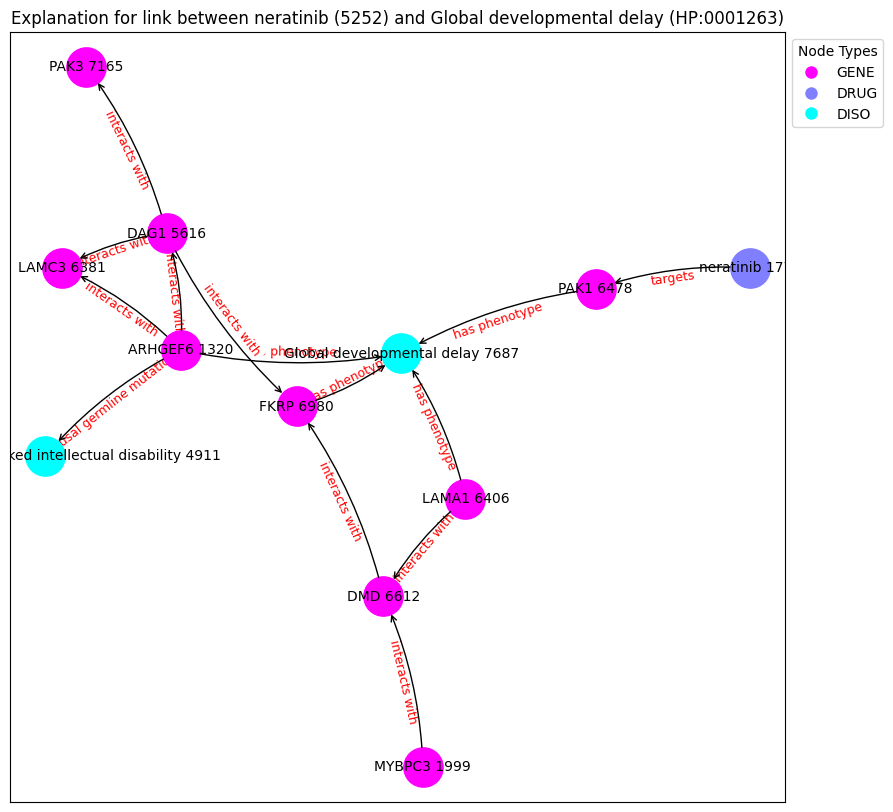

('ARHGEF6 1320', {'type': 'GENE'})
('neratinib 1772', {'type': 'DRUG'})
('MYBPC3 1999', {'type': 'GENE'})
('non-syndromic X-linked intellectual disability 4911', {'type': 'DISO'})
('DAG1 5616', {'type': 'GENE'})
('LAMC3 6381', {'type': 'GENE'})
('LAMA1 6406', {'type': 'GENE'})
('PAK1 6478', {'type': 'GENE'})
('DMD 6612', {'type': 'GENE'})
('FKRP 6980', {'type': 'GENE'})
('PAK3 7165', {'type': 'GENE'})
('Global developmental delay 7687', {'type': 'DISO'})
('ARHGEF6 1320', 'LAMC3 6381', {'label': 'interacts with'})
('ARHGEF6 1320', 'DAG1 5616', {'label': 'interacts with'})
('ARHGEF6 1320', 'Global developmental delay 7687', {'label': 'has phenotype'})
('ARHGEF6 1320', 'non-syndromic X-linked intellectual disability 4911', {'label': 'is causal germline mutation in'})
('neratinib 1772', 'PAK1 6478', {'label': 'targets'})
('MYBPC3 1999', 'DMD 6612', {'label': 'interacts with'})
('DAG1 5616', 'LAMC3 6381', {'label': 'interacts with'})
('DAG1 5616', 'PAK3 7165', {'label': 'interacts with'})
(

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


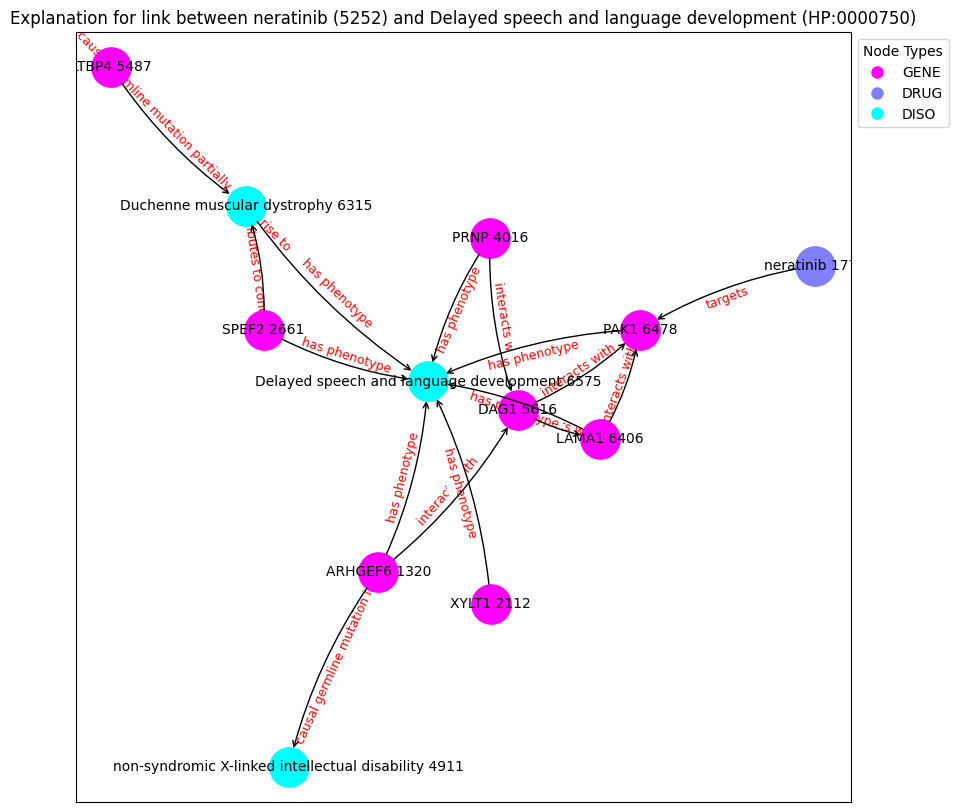

('ARHGEF6 1320', {'type': 'GENE'})
('neratinib 1772', {'type': 'DRUG'})
('XYLT1 2112', {'type': 'GENE'})
('SPEF2 2661', {'type': 'GENE'})
('PRNP 4016', {'type': 'GENE'})
('non-syndromic X-linked intellectual disability 4911', {'type': 'DISO'})
('LTBP4 5487', {'type': 'GENE'})
('DAG1 5616', {'type': 'GENE'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('LAMA1 6406', {'type': 'GENE'})
('PAK1 6478', {'type': 'GENE'})
('Delayed speech and language development 6575', {'type': 'DISO'})
('ARHGEF6 1320', 'DAG1 5616', {'label': 'interacts with'})
('ARHGEF6 1320', 'Delayed speech and language development 6575', {'label': 'has phenotype'})
('ARHGEF6 1320', 'non-syndromic X-linked intellectual disability 4911', {'label': 'is causal germline mutation in'})
('neratinib 1772', 'PAK1 6478', {'label': 'targets'})
('XYLT1 2112', 'Delayed speech and language development 6575', {'label': 'has phenotype'})
('SPEF2 2661', 'Duchenne muscular dystrophy 6315', {'label': 'contributes to condition'})


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


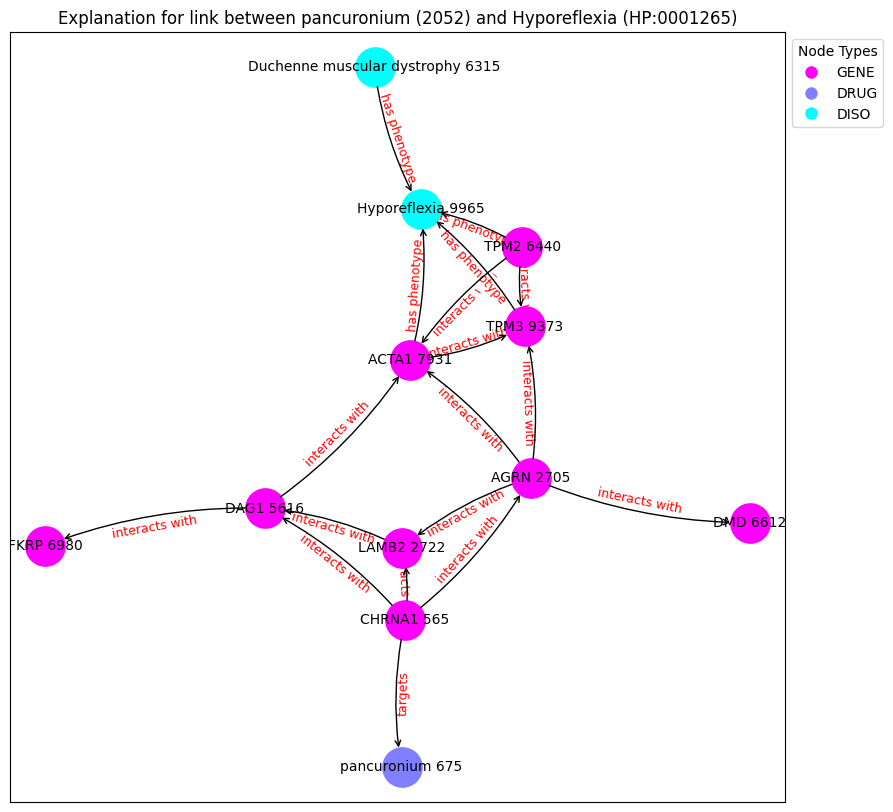

('CHRNA1 565', {'type': 'GENE'})
('pancuronium 675', {'type': 'DRUG'})
('AGRN 2705', {'type': 'GENE'})
('LAMB2 2722', {'type': 'GENE'})
('DAG1 5616', {'type': 'GENE'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('TPM2 6440', {'type': 'GENE'})
('DMD 6612', {'type': 'GENE'})
('FKRP 6980', {'type': 'GENE'})
('ACTA1 7931', {'type': 'GENE'})
('TPM3 9373', {'type': 'GENE'})
('Hyporeflexia 9965', {'type': 'DISO'})
('CHRNA1 565', 'LAMB2 2722', {'label': 'interacts with'})
('CHRNA1 565', 'DAG1 5616', {'label': 'interacts with'})
('CHRNA1 565', 'AGRN 2705', {'label': 'interacts with'})
('CHRNA1 565', 'pancuronium 675', {'label': 'targets'})
('AGRN 2705', 'TPM3 9373', {'label': 'interacts with'})
('AGRN 2705', 'ACTA1 7931', {'label': 'interacts with'})
('AGRN 2705', 'DMD 6612', {'label': 'interacts with'})
('AGRN 2705', 'LAMB2 2722', {'label': 'interacts with'})
('LAMB2 2722', 'DAG1 5616', {'label': 'interacts with'})
('DAG1 5616', 'ACTA1 7931', {'label': 'interacts with'})
('DAG1 561

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


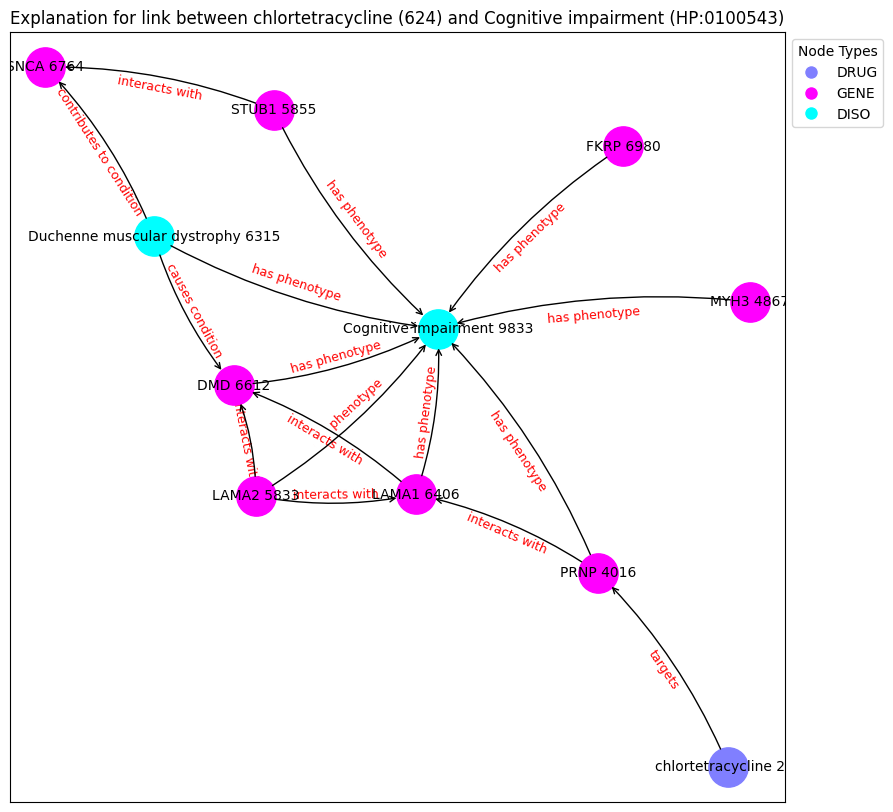

('chlortetracycline 208', {'type': 'DRUG'})
('PRNP 4016', {'type': 'GENE'})
('MYH3 4867', {'type': 'GENE'})
('LAMA2 5833', {'type': 'GENE'})
('STUB1 5855', {'type': 'GENE'})
('Duchenne muscular dystrophy 6315', {'type': 'DISO'})
('LAMA1 6406', {'type': 'GENE'})
('DMD 6612', {'type': 'GENE'})
('SNCA 6764', {'type': 'GENE'})
('FKRP 6980', {'type': 'GENE'})
('Cognitive impairment 9833', {'type': 'DISO'})
('chlortetracycline 208', 'PRNP 4016', {'label': 'targets'})
('PRNP 4016', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('PRNP 4016', 'LAMA1 6406', {'label': 'interacts with'})
('MYH3 4867', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('LAMA2 5833', 'DMD 6612', {'label': 'interacts with'})
('LAMA2 5833', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('LAMA2 5833', 'LAMA1 6406', {'label': 'interacts with'})
('STUB1 5855', 'Cognitive impairment 9833', {'label': 'has phenotype'})
('STUB1 5855', 'SNCA 6764', {'label': 'interacts with'})
('Duchenne muscular 

In [42]:
explanations_stats = {}

for i, explanation in enumerate(found_explanation):
    nodes_idxs = torch.Tensor([explanation['node_idx1'], explanation['node_idx2']]).long()
    
    drug_id = explanation['drug']
    drug_name = nodes.loc[nodes['id'] == drug_id]['label'].iloc[0]
    
    symptom_id = explanation['symptom']
    symptom_name = nodes.loc[nodes['id'] == symptom_id]['label'].iloc[0]
    
    explanation_title = f"Explanation for link between {drug_name} ({drug_id}) and {symptom_name} ({symptom_id})"

    plt.figure(figsize=(10, 10))
    plt.title(explanation_title)
    ax, G_sub = visualize_subgraph(nodes_idxs, edge_index, explanation['found_edge_mask'], 
                                   nodes=nodes, node_labels_dict=node_labels_dict, y=torch.Tensor(nodes.semantic_id), 
                                   seed=667, num_hops=num_hops, 
                                   threshold=explanation['found_limit'], 
                                   node_label='label', edge_labels=edge_labels_dict, 
                                   show_inactive=False, remove_unconnected=True)

    explanations_stats[i] = count_occurrences(G_sub)
    
    plt.savefig(f'{expl_output_dir}/explanation_{i}.png', bbox_inches='tight')
    plt.show()
    
    # See https://networkx.org/documentation/stable/release/migration_guide_from_2.x_to_3.0.html#deprecated-code
    with open(f'{expl_output_dir}/explanation_{i}_graph.gpickle', 'wb') as f:
        pickle.dump(get_graph_to_save(G_sub), f, pickle.HIGHEST_PROTOCOL)
        
with open(f'{expl_output_dir}/explanation_stats.pkl', 'wb') as f:
    pickle.dump(explanations_stats, f)